## Settings

In [2]:
%load_ext autoreload
%autoreload 2

# Standard libraries
import os
import re
import gc
import copy
import math
import random
import warnings
import pickle
import shutil
from math import sqrt
from tqdm.notebook import tqdm

# Data processing and analysis
import numpy as np
from numpy.lib.format import open_memmap
import pandas as pd
import vitaldb
import scipy.signal
from scipy import stats
from scipy.stats import spearmanr
from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt
from lifelines import KaplanMeierFitter, statistics

# Machine learning
import torch
import torch.jit
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
import optuna
import lightgbm as lgb
from sklearn.experimental import enable_iterative_imputer

# Scikit-learn
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.impute import IterativeImputer
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

# Explainability
import shap
import ml_insights as mli
import json
from delong import *
from plot_model import *
from utils import setup_logger

# Suppress warnings
warnings.filterwarnings('ignore')

# Clear GPU memory if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Global constants
SEGLEN = 120*80
MAX_CASES = 100
C = 6
CV = 5
SEED = 98
LR = 5e-4
BATCH = 16

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Graph adjacency matrix for EEG channels
adj = torch.zeros(6, 6, dtype=torch.float32)
adj[adj == 0] = 0.5
adj[0, 1] = adj[1, 0] = 1  # L1 <-> L2
adj[0, 4] = adj[4, 0] = 1  # L1 <-> L
adj[1, 4] = adj[4, 1] = 1  # L2 <-> L
adj[2, 3] = adj[3, 2] = 1  # R1 <-> R2
adj[2, 5] = adj[5, 2] = 1  # R1 <-> R
adj[3, 5] = adj[5, 3] = 1  # R2 <-> R
adj += torch.eye(6, dtype=torch.float32)

D = torch.sum(adj, dim=1)
D_sqrt_inv = torch.diag(torch.pow(D, -0.5))
adj = torch.mm(torch.mm(D_sqrt_inv, adj), D_sqrt_inv)
adj = adj.to(device)

features = ['age', 'sex', 'sr_auc', 'sr_duration', 'psi_duration']#
model_configs = {
    'xgb': {'class': xgb.XGBClassifier, 'column': 'y_test_proba_xgb'},
    #'et': {'class': ExtraTreesClassifier, 'column': 'y_test_proba_et'},
    'lgb': {'class': lgb.LGBMClassifier, 'column': 'y_test_proba_lgb'},
    'rf': {'class': RandomForestClassifier, 'column': 'y_test_proba_rf'},
    'gb': {'class': GradientBoostingClassifier, 'column': 'y_test_proba_gb'}
}

# Dataset class
class ChunkedDataset(Dataset):
    def __init__(self, X_data, ages, sexes, labels):
        self.X_data = X_data        # Memory-mapped array
        self.ages = ages
        self.sexes = sexes
        self.labels = labels
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        # Get the original index
        # Load just this one sample
        X = torch.tensor(self.X_data[idx], dtype=torch.float32)
        age = torch.tensor([self.ages[idx]], dtype=torch.float32)
        sex = torch.tensor([self.sexes[idx]], dtype=torch.float32)
        label = torch.tensor([self.labels[idx]], dtype=torch.float32)
        return X, age, sex, label

class GraphConvolution(nn.Module):
    """
    Simple GCN layer.
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
        
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return x
    
class CombinedGCNCNN(nn.Module):
    def __init__(self, adj):
        super(CombinedGCNCNN, self).__init__()
        
        nfeat = SEGLEN  
        nhid = 100     
        nclass = SEGLEN 
        dropout = 0.3  

        self.gcn = GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout)
        self.adj = adj
        
        self.conv1 = nn.Conv1d(C, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm1d(32)  
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(64)  
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm1d(128)  
        self.fc1 = nn.Linear(128 * (SEGLEN // 8), 256) 
        self.bn_fc1 = nn.BatchNorm1d(256)  
        self.fc2 = nn.Linear(256+2, 1)
        self.relu = nn.ReLU()
        
        self.embedding_dim = 128
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=4, dim_feedforward=256, dropout=0.2, batch_first=True), 
            num_layers=2)
        
    def forward(self, x, age, sex, adj):
        B, C, L = x.shape
        gcn_x = x.view(B, L, C).permute(0, 2, 1) 
        gcn_out = self.gcn(gcn_x, self.adj)
        gcn_out = gcn_out.view(B, C, L)  
        enhanced_x = x + gcn_out
        x = self.relu(self.conv1(enhanced_x))
        x = self.bn1(x) if B>1 else x
        x = self.relu(self.conv2(x))
        x = self.bn2(x) if B>1 else x
        x = self.relu(self.conv3(x))
        x = self.bn3(x) if B>1 else x
        x = x.permute(0, 2, 1)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.bn_fc1(x) if B>1 else x
        x = self.fc2(torch.cat([x, age, sex], dim=1))
        x = torch.sigmoid(x)
        return x


def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

def set_seeds(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def youden(y_true, y_score):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    y_true = y_true.ravel()
    y_score = y_score.ravel()
    
    try:
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        if len(thresholds) == 0:
            print("Warning: No thresholds found")
            return 0.5
        J = tpr - fpr
        idx = np.argmax(J)
        return thresholds[idx]
    except Exception as e:
        print(f"Error in Youden calculation: {str(e)}")
        return 0.5

def process_vital_files(dataframe):
    dataframe['sr_auc'] = np.nan
    dataframe['sr_duration'] = np.nan
    dataframe['psi_duration'] = np.nan
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Processing files"):
        filename = row['filename']
        try:
            vf = vitaldb.VitalFile('data_psi/'+str(filename)+'.vital')
            vf2 = vitaldb.VitalFile('data_artf/'+str(filename)+'.vital')
            if 'ROOT/SR' in vf.trks:
                sr = vf.to_numpy('ROOT/SR', 1/vf.trks['ROOT/SR'].srate, return_timestamp=False)
                artf = vf2.to_numpy('ROOT/ARTF', 1/vf2.trks['ROOT/ARTF'].srate, return_timestamp=False)
                if len(sr) > len(artf):
                    artf = np.append(artf, np.full((len(sr) - len(artf), 1), np.nan), axis=0)
                elif len(artf) > len(sr):
                    sr = np.append(sr, np.full((len(artf) - len(sr), 1), np.nan), axis=0)
                mask = artf == 0
                sr = sr[mask]
                ############################
                sr_filtered = sr[(sr > 1) & (sr<100)]
                if len(sr_filtered) > 0:
                    time_step = 1/vf.trks['ROOT/SR'].srate
                    time_filtered = np.arange(len(sr_filtered)) * time_step
                    sr_auc = np.trapz(sr_filtered, x=time_filtered)
                    sr_duration = len(sr_filtered) * time_step
                    dataframe.at[idx, 'sr_auc'] = sr_auc/100
                    dataframe.at[idx, 'sr_duration'] = sr_duration
                else: 
                    dataframe.at[idx, 'sr_auc'] = 0
                    dataframe.at[idx, 'sr_duration'] = 0
            if 'ROOT/PSI' in vf.trks:
                psi = vf.to_numpy('ROOT/PSI', 1/vf.trks['ROOT/PSI'].srate, return_timestamp=False)
                artf = vf2.to_numpy('ROOT/ARTF', 1/vf2.trks['ROOT/ARTF'].srate, return_timestamp=False)
                if len(psi) > len(artf):
                    artf = np.append(artf, np.full((len(psi) - len(artf), 1), np.nan), axis=0)
                elif len(artf) > len(psi):
                    psi = np.append(psi, np.full((len(artf) - len(psi), 1), np.nan), axis=0)
                mask = artf == 0
                psi = psi[mask]
                psi_filtered = psi[(psi < 25)&(psi > 0)]
                if len(psi_filtered) > 0:
                    psi_time_step = 1/vf.trks['ROOT/PSI'].srate
                    psi_duration = len(psi_filtered) * psi_time_step
                    dataframe.at[idx, 'psi_duration'] = psi_duration
                else: 
                    dataframe.at[idx, 'psi_duration'] =0
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    return dataframe

def create_objective_function(model_type, model_class, param_grid_fn, features=features):
    def objective(trial, df_train, cv=CV):
        param_grid = param_grid_fn(trial)
        
        h = df_train['hid'].unique()
        groups = np.array(range(len(h)))
        h_shuffled, groups_shuffled = shuffle(h, groups, random_state=SEED)
        
        group_kf = GroupKFold(n_splits=cv)
        cv_scores = np.empty(cv)
        
        for idx, (train_h, val_h) in enumerate(group_kf.split(h_shuffled, groups=groups_shuffled)):
            X_train = df_train[df_train['hid'].isin(h_shuffled[train_h])][features]
            X_valid = df_train[df_train['hid'].isin(h_shuffled[val_h])][features]
            y_train = df_train.loc[df_train['hid'].isin(h_shuffled[train_h]), 'label'].values
            y_valid = df_train.loc[df_train['hid'].isin(h_shuffled[val_h]), 'label'].values
            
            model = model_class(**param_grid)
            
            if model_type == 'xgb':
                model.fit(X_train, y_train, verbose=False)
            else:
                model.fit(X_train, y_train)
                
            cv_scores[idx] = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
        
        mean_cv_score = np.mean(cv_scores)      
        try:
            if mean_cv_score > trial.study.best_value:          
                with open(f'best_params_{model_type}.json', 'w') as f:
                    json.dump(param_grid, f, indent=4)
        except ValueError:
            with open(f'best_params_{model_type}.json', 'w') as f:
                json.dump(param_grid, f, indent=4)
        
        return mean_cv_score
    
    return objective

def xgb_params(trial):
    return {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1600, 200),
        'eta': trial.suggest_float('eta', 0.005, 0.05),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.9),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1, 1e3),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1, 1e3),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 1e3),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1e2),
        'random_state': SEED,
        'enable_categorical': True
    }

def lgb_params(trial):
    return {
        'verbose':-1,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': SEED
    }

def rf_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': SEED
    }

def gb_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'random_state': SEED
    }

def train_fold(X_train, y_train, a_train, s_train, X_val, y_val, a_val, s_val, fold_num):
    train_dataset = ChunkedDataset(X_train, a_train, s_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
    val_dataset = ChunkedDataset(X_val, a_val, s_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)

    train_label_0 = np.sum(y_train[:, None] == 0)
    train_label_1 = np.sum(y_train[:, None] == 1)
    val_label_0 = np.sum(y_val[:, None] == 0)
    val_label_1 = np.sum(y_val[:, None] == 1)

    print(f"Fold {fold_num} - Training set - Label 0: {train_label_0}, Label 1: {train_label_1}")
    print(f"Fold {fold_num} - Validation set - Label 0: {val_label_0}, Label 1: {val_label_1}")

    epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CombinedGCNCNN(adj=adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    criterion = nn.BCELoss()

    best_val_auroc = 0
    patience = 2
    early_stopping_counter = 0
    best_epoch = 0

    for epoch in range(epochs):
        clear_memory()
        model.train()
        running_loss = 0.0
        train_preds = []
        train_targets = []
        train_pbar = tqdm(train_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{epochs} [Train]')
        optimizer.zero_grad()  
    
        for _, (inputs, age, sex, targets) in enumerate(train_pbar):
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            outputs = model(inputs, age, sex, adj)
            bce_loss = criterion(outputs, targets)

            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            
            reg_coef = 0.001
            loss = bce_loss + reg_coef * l2_reg
            loss.backward()

            train_preds.extend(outputs.detach().cpu().numpy())
            train_targets.extend(targets.detach().cpu().numpy())
            running_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

            del inputs, age, sex, targets, outputs, loss, bce_loss, l2_reg
            clear_memory()
            train_pbar.set_postfix({'BCE': f'{running_loss/len(train_preds):.4f}'})
        
        train_preds = np.array(train_preds)
        train_targets = np.array(train_targets)
        train_targets_binary = (train_targets > 0.5).astype(int)
        
        train_metrics = {}
        if len(np.unique(train_targets_binary)) == 2:
            train_metrics['auroc'] = roc_auc_score(train_targets_binary, train_preds)
            train_metrics['auprc'] = average_precision_score(train_targets_binary, train_preds)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{epochs} [Val]')
            for inputs, age, sex, targets in val_pbar:
                inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
                outputs = model(inputs, age, sex, adj)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_targets.extend(targets.detach().cpu().numpy())
                val_pbar.set_postfix({'BCE': f'{loss.item():.4f}'})
        
        val_preds = np.array(val_preds)
        val_targets = np.array(val_targets)
        val_targets_binary = val_targets
        
        val_metrics = {}
        if len(np.unique(val_targets_binary)) == 2:
            val_metrics['auroc'] = roc_auc_score(val_targets_binary, val_preds)
            val_metrics['auprc'] = average_precision_score(val_targets_binary, val_preds)
        
        epoch_val_loss = val_loss/len(val_loader)
        print(f"Fold {fold_num} - Epoch {epoch+1}/{epochs}")
        print(f"Train - BCE Loss: {running_loss/len(train_preds):.4f}, AUROC: {train_metrics.get('auroc', 0):.4f}, AUPRC: {train_metrics.get('auprc', 0):.4f}")
        print(f"Val   - BCE Loss: {epoch_val_loss:.4f}, AUROC: {val_metrics.get('auroc', 0):.4f}, AUPRC: {val_metrics.get('auprc', 0):.4f}")
        
        if val_metrics and (epoch == 0 or val_metrics['auroc'] > best_val_auroc):
            best_val_auroc = val_metrics['auroc']
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            early_stopping_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auroc': best_val_auroc,
                'train_metrics': train_metrics,
                'val_metrics': val_metrics
            }, f'best_model_fold_{fold_num}.pth')
            print(f"New best model saved with validation AUROC: {best_val_auroc:.4f}")
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs. No improvement in validation AUROC for {patience} epochs.")
            break
    steps_per_epoch = len(train_loader)
    total_steps = (best_epoch + 1) * steps_per_epoch
    print(f"Fold {fold_num} training completed. Best validation AUROC: {best_val_auroc:.4f} at epoch {best_epoch+1}")
    print(f"Step size for fold {fold_num}: {total_steps}")
    return total_steps

def extract_frequency_bands(eeg_data, sampling_rate=SEGLEN/120):
    eeg_np = eeg_data.detach().cpu().numpy()
    n_channels, n_samples = eeg_np.shape
    bands = {
        "Noise": (0.5,1),
        "Delta": (1,4),
        "Theta": (4,8),
        "Alpha": (8, 12),
        "High": (12,40-10e-10),
        "Total_plus":(0.5,40-10e-10),
        "Total": (1, 40-10e-10)
    }
    freqs, psd = scipy.signal.welch(eeg_np, fs=sampling_rate, 
                                   nperseg=160,noverlap=120, scaling='density',
                                   axis=1)
    results = {'absolute': {}, 'relative': {}, 'timeseries': {}}

    band_powers = {}
    for band, (f_low, f_high) in bands.items():
        idx = np.logical_and(freqs >= f_low, freqs <= f_high)
        band_power = np.trapz(psd[:,idx], freqs[idx], axis=1).sum()
        band_powers[band] = band_power

    for band in ["Delta", "Theta", "Alpha"]:
        power = 10 * np.log10(band_powers[band])
        rel_power = band_powers[band]/band_powers["Total"]
        results[band] = torch.tensor(power, dtype=torch.float32)
        results['relative'][band]= torch.tensor(rel_power, dtype=torch.float32)
    for band in ["Noise","High"]:
        power = 10 * np.log10(band_powers[band])
        rel_power = band_powers[band]/band_powers["Total_plus"]
        results[band] = torch.tensor(power, dtype=torch.float32)
        results['relative'][band]= torch.tensor(rel_power, dtype=torch.float32)        
    return results

def calculate_regression_with_ci(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    n = len(x)
    mean_x = np.mean(x)
    ss_x = np.sum((x - mean_x)**2)
    se = np.sqrt(np.sum((y - (slope * x + intercept))**2) / (n - 2))
    se_slope = se / np.sqrt(ss_x)
    se_intercept = se * np.sqrt(1/n + mean_x**2/ss_x)
    t_value = stats.t.ppf(0.975, n-2)
    ci_slope = (slope - t_value * se_slope, slope + t_value * se_slope)
    ci_intercept = (intercept - t_value * se_intercept, intercept + t_value * se_intercept)
    x_min, x_max = np.min(x), np.max(x)
    x_line = np.linspace(x_min, x_max, 100)
    y_line = slope * x_line + intercept
    se_y_pred = se * np.sqrt(1/n + (x_line - mean_x)**2 / ss_x)
    y_lower = y_line - t_value * se_y_pred
    y_upper = y_line + t_value * se_y_pred
    return {
        'slope': slope, 
        'intercept': intercept, 
        'ci_slope': ci_slope, 
        'ci_intercept': ci_intercept,
        'x_line': x_line, 
        'y_line': y_line, 
        'y_lower': y_lower, 
        'y_upper': y_upper
    }

def run_frequency_analysis(model_path, test_file='test_ids.npy', SEGNUM=10):
    X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
    Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
    ID = np.load('C_f.npy', mmap_mode='r')
    FILE = np.load('F_f.npy', mmap_mode='r')
    A = np.load('A_f.npy', mmap_mode='r')
    S = np.load('S_f.npy', mmap_mode='r')
    checkpoint = torch.load(model_path, map_location=device)
    model = CombinedGCNCNN(adj=adj).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    del checkpoint
    test_ids = np.load(test_file, allow_pickle=True)
    test_mask = np.isin(ID, test_ids)
    X_test = X_normalized[test_mask] 
    y_test = Y_normalized[test_mask]
    a_test = A[test_mask]
    s_test = S[test_mask]
    id_test = FILE[test_mask]
    del X_normalized, Y_normalized, A, S, test_mask
    channel_names = ["L1", "L2", "R1", "R2", "L", "R"]
    batch_size = 16
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
    sample_data = {
        'id': [],
        'prob': [],
        'Delta': [],
        'Theta': [],
        'Alpha': [],
        'relative_Delta': [],
        'relative_Theta': [],
        'relative_Alpha': []
    }
    for i in tqdm(range(0, len(X_test), batch_size), desc="Processing test data"):
        batch_indices = list(range(i, min(i+batch_size, len(X_test))))
        x_batch = torch.tensor(X_test[batch_indices], dtype=torch.float32).to(device)
        age_batch = torch.tensor(a_test[batch_indices], dtype=torch.float32).unsqueeze(1).to(device)
        sex_batch = torch.tensor(s_test[batch_indices], dtype=torch.float32).unsqueeze(1).to(device)
        with torch.no_grad():
            batch_preds = model(x_batch, age_batch, sex_batch, adj)
        
        for j, idx in enumerate(batch_indices):
            batch_idx = j
            true_label = y_test[idx]
            pred = batch_preds[batch_idx].item()
            sample_id = id_test[idx]
            
            x_sample = torch.tensor(X_test[idx], dtype=torch.float32).unsqueeze(0).to(device)
            frequency_bands = extract_frequency_bands(x_sample.squeeze(0))
            
            sample_data['id'].append(sample_id)
            sample_data['prob'].append(pred)
            
            for band_name in ['Delta', 'Theta', 'Alpha']:
                if band_name in frequency_bands:
                    sample_data[band_name].append(frequency_bands[band_name].item())
                    
                    rel_band_data = frequency_bands['relative'][band_name]
                    rel_band_mean = torch.mean(rel_band_data).item()
                    sample_data[f'relative_{band_name}'].append(rel_band_mean)
        del x_batch, age_batch, sex_batch, batch_preds
    
    # Ensure all lists in sample_data have the same length
    min_length = min(len(sample_data[key]) for key in sample_data)
    for key in sample_data:
        sample_data[key] = sample_data[key][:min_length]
        
    df = pd.DataFrame(sample_data)
    grouped_data = df.groupby('id').mean().reset_index()
    
    for i, band_name in enumerate(['Delta', 'Theta', 'Alpha']):
        col_name = f"relative_{band_name}"
        if col_name in grouped_data.columns:
            axes[0, i].scatter(grouped_data['prob'], grouped_data[col_name], s=1)
            r, p = stats.spearmanr(grouped_data['prob'], grouped_data[col_name])
            reg_results = calculate_regression_with_ci(grouped_data['prob'], grouped_data[col_name])
            x_line = np.linspace(0, 1, 100)
            y_line = reg_results['slope'] * x_line + reg_results['intercept']
            n = len(grouped_data['prob'])
            mean_x = np.mean(grouped_data['prob'])
            ss_x = np.sum((grouped_data['prob'] - mean_x)**2)
            se = np.sqrt(np.sum((grouped_data[col_name] - (reg_results['slope'] * grouped_data['prob'] + reg_results['intercept']))**2) / (n - 2))
            t_value = stats.t.ppf(0.975, n-2)
            se_y_pred = se * np.sqrt(1/n + (x_line - mean_x)**2 / ss_x)
            y_lower = y_line - t_value * se_y_pred
            y_upper = y_line + t_value * se_y_pred
            axes[0, i].plot(x_line, y_line, 'r-', lw=0.8)
            axes[0, i].fill_between(x_line, y_lower, y_upper, color='red', alpha=0.1)
            print(f"{band_name} relative")
            print(f"Spearman's ρ={r:.3f}, p={p:.3f}")
            print(f"β={reg_results['slope']:.3f} [{reg_results['ci_slope'][0]:.3f}, {reg_results['ci_slope'][1]:.3f}], α={reg_results['intercept']:.3f} [{reg_results['ci_intercept'][0]:.3f}, {reg_results['ci_intercept'][1]:.3f}]")
            axes[0, i].set_ylim(0, 0.65)
            axes[0, i].set_xlabel('Prediction Probability of DELPHI-EEG')
            axes[0, i].set_ylabel(f'{band_name} Wave Relative Band Power')
            axes[0, i].grid(True, alpha=0.3)
        else:
            axes[0, i].set_visible(False)
    for i in range(3):
        axes[1, i].set_visible(False)
    plt.show()
    del X_test, y_test, a_test, s_test, id_test, ID

def evaluate_model(model, data_loader, device, youden_threshold, calib):
    model.eval()
    test_preds_all_models = []
    test_targets = []
    with torch.no_grad():
        test_pbar = tqdm(data_loader, desc=f'[Test]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            model.eval()
            outputs = model(inputs, age, sex, adj)
            test_preds_all_models.extend(outputs.detach().cpu().numpy())
            test_targets.extend(targets.detach().cpu().numpy())
    test_preds = np.array(test_preds_all_models).ravel()
    test_targets = np.array(test_targets)
    test_preds = calib.calibrate(test_preds)
    y_pred_test = (test_preds > youden_threshold).astype(int)
    class1_f1 = f1_score(test_targets, y_pred_test)
    
    return class1_f1

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## EEG Preprocessing

In [ ]:
x2= pd.read_csv('delirium_old.csv', encoding='cp949', encoding_errors='ignore')
x1= pd.read_csv('eeg_rid_supreme_sampled.csv')
sex_mapping = dict(zip(x2['연구별 환자 ID'], x2['성별']))
x1['sex'] = x1['hid'].map(sex_mapping)
x1['sex'] = x1['sex'].map({'M': 1, 'F': 0})

chs = ['ROOT/EEG_L1', 'ROOT/EEG_L2', 'ROOT/EEG_R1', 'ROOT/EEG_R2', 'ROOT/EEG_L', 'ROOT/EEG_R']
x_list = []
y_list = []
c_list = []
f_list = []
a_list = []
s_list = []
p_list = []

new_srate =SEGLEN/120
for idx in tqdm(range(len(x1))):
    try:
        vf = vitaldb.VitalFile('data/'+x1.loc[idx,'filename']+'.vital')
            
        wf_list = []
        for ch in chs:
            wf_single_orig = vf.to_numpy(ch, 1/vf.trks[ch].srate, return_timestamp=False)
            t_orig = np.arange(len(wf_single_orig)) / vf.trks[ch].srate
            
            t_new = np.arange(0, t_orig[-1], 1/new_srate)
            
            wf_single = np.interp(t_new, t_orig, wf_single_orig.ravel())
            wf_list.append(wf_single)
            
            del wf_single_orig, t_orig, t_new, wf_single
            
        wf = np.column_stack(wf_list)
        del wf_list

        try:
            psi_raw = vf.to_numpy('ROOT/SR', 1/vf.trks['ROOT/SR'].srate, return_timestamp=False).ravel()
            t_orig = np.arange(len(psi_raw)) / vf.trks['ROOT/SR'].srate
            t_new = np.linspace(0, t_orig[-1], len(wf))
            psi = np.interp(t_new, t_orig, psi_raw)
            del psi_raw, t_orig, t_new
        except:
            psi = np.full(len(wf), np.nan)

        srate = new_srate
        window_size = int(srate*120)
        
        total_mean = np.nanmean(wf)
        total_std = np.nanstd(wf)

        best_chunks = []
        best_psi_chunks = []
        best_z_scores = []
        
        stride = int(srate*40)
        for i in range(0, len(wf) - window_size + 1, stride):
            EXTRACT_SIZE =30
            chunk = wf[i:i+window_size]
            psi_chunk = np.nanmean(psi[i:i+window_size])
            if not np.isnan(chunk).any():
                chunk_mean = np.mean(chunk)
                z_score = abs((chunk_mean - total_mean) / total_std)
                
                if len(best_chunks) < EXTRACT_SIZE:
                    best_chunks.append(chunk)
                    best_z_scores.append(z_score)
                    best_psi_chunks.append(psi_chunk)
                    if (len(best_chunks) == EXTRACT_SIZE) | (i==(len(wf) - window_size - ((len(wf) - window_size) % stride))):
                        indices = np.argsort(best_z_scores)
                        best_chunks = [best_chunks[i] for i in indices]
                        best_z_scores = [best_z_scores[i] for i in indices]
                        best_psi_chunks = [best_psi_chunks[i] for i in indices]
                        if i==(len(wf) - window_size - ((len(wf) - window_size) % stride)):
                            EXTRACT_SIZE = len(best_chunks)
                elif z_score < best_z_scores[-1]:
                    best_chunks[-1] = chunk
                    best_z_scores[-1] = z_score
                    best_psi_chunks[-1] = psi_chunk
                    indices = np.argsort(best_z_scores)
                    best_chunks = [best_chunks[i] for i in indices]
                    best_z_scores = [best_z_scores[i] for i in indices]
                    best_psi_chunks = [best_psi_chunks[i] for i in indices]
                
                del chunk_mean, z_score
            elif (i==(len(wf) - window_size - ((len(wf) - window_size) % stride))):
                indices = np.argsort(best_z_scores)
                best_chunks = [best_chunks[i] for i in indices]
                best_z_scores = [best_z_scores[i] for i in indices]
                best_psi_chunks = [best_psi_chunks[i] for i in indices]
                EXTRACT_SIZE = len(best_chunks)

        selected_chunks = np.array(best_chunks)
        selected_psi_chunks = np.array(best_psi_chunks)
        if selected_chunks.shape[1] != int(new_srate*120):
            del selected_chunks, selected_psi_chunks, best_chunks, best_psi_chunks, best_z_scores, wf, psi, vf
            continue
        if selected_chunks.shape[0] != EXTRACT_SIZE:
            print(f"PROBLEM, {selected_chunks.shape[0]}, {EXTRACT_SIZE}, {i}, {(len(wf) - window_size - ((len(wf) - window_size) % stride))}")
        x_list.append(selected_chunks.astype(np.float32))
        p_list.append(selected_psi_chunks)
        
        new_labels = np.array([x1.loc[idx,'label']] * EXTRACT_SIZE)
        new_hids = np.array([x1.loc[idx,'hid']] * EXTRACT_SIZE)
        new_files = np.array([x1.loc[idx,'filename']] * EXTRACT_SIZE)
        new_ages = np.array([x1.loc[idx,'age']] * EXTRACT_SIZE)
        new_sexes = np.array([x1.loc[idx,'sex']] * EXTRACT_SIZE)
        
        y_list.append(new_labels)
        c_list.append(new_hids)
        f_list.append(new_files)
        a_list.append(new_ages)
        s_list.append(new_sexes)
            
        del selected_chunks, selected_psi_chunks, best_chunks, best_psi_chunks
        del best_z_scores, wf, psi, vf, new_labels, new_hids, new_files
        del new_ages, new_sexes
        
    except FileNotFoundError:
        print(f"File not found: {x1.loc[idx,'filename']}")  
        continue
    except Exception as e:
        continue

if len(x_list) > 0:
    x = np.vstack(x_list)
    p = np.concatenate(p_list)
    y = np.concatenate(y_list)
    c = np.concatenate(c_list)
    f = np.concatenate(f_list)
    a = np.concatenate(a_list)
    s = np.concatenate(s_list)
else:
    x = np.array([])
    p = np.array([])
    y = np.array([])
    c = np.array([])
    f = np.array([])
    a = np.array([])
    s = np.array([])

x = np.transpose(x, (0, 2, 1))
np.save('X.npy', x)
np.save('Y.npy', y)
np.save('C.npy', c)
np.save('F.npy', f)
np.save('A.npy', a)
np.save('S.npy', s)
np.save('P.npy', p)
print(f"Saved arrays with shapes: X:{x.shape}, Y:{y.shape}, C:{c.shape}, A:{a.shape}, S:{s.shape}, F:{f.shape}, P:{p.shape}")

In [ ]:
X = np.load('X.npy', mmap_mode='r')
X_normalized = open_memmap('X_normalized.npy', dtype='float32', 
                          mode='w+', shape=X.shape)
ID = np.load('C.npy', mmap_mode='r')
train_ids = np.load('train_ids_5.npy', allow_pickle=True)
train_mask = np.isin(ID, train_ids)
X_train = X[train_mask]

X_mean = np.mean(X_train, dtype=np.float32)
X_std = np.float64(0)
for i in tqdm(range(0, len(X_train), 1000), desc="Calculating X std"):
    batch = X_train[i:i+1000].astype(np.float32)
    X_std += np.sum((batch - X_mean) ** 2, dtype=np.float64)
X_std = np.sqrt(X_std / (len(X_train) - 1)).astype(np.float32)

for i in tqdm(range(0, len(X), 1000), desc="Normalizing X"):
    batch = X[i:i+1000].astype(np.float32)
    normalized_batch = (batch - X_mean) / X_std
    X_normalized[i:i+1000] = normalized_batch
    X_normalized.flush()
    del batch, normalized_batch
del X_normalized 

In [ ]:
X_normalized = np.load('X_normalized.npy', mmap_mode='r')
Y_normalized = np.load('Y.npy', mmap_mode='r')
ID = np.load('C.npy', mmap_mode='r')
FILE = np.load('F.npy', mmap_mode='r')
A = np.load('A.npy', mmap_mode='r')
S = np.load('S.npy', mmap_mode='r')
P = np.load('P.npy', mmap_mode='r')
P = P.flatten()

print("Original data shapes:", X_normalized.shape, Y_normalized.shape)
print("Checking for uniform channels...")

valid_samples = []
total_samples = X_normalized.shape[0]

for i in tqdm(range(total_samples)):
    has_uniform_channel = False
    for channel in range(X_normalized.shape[1]):
        if np.all(X_normalized[i, channel, :] == X_normalized[i, channel, 0]):
            has_uniform_channel = True
            break
    
    if not has_uniform_channel:
        valid_samples.append(i)

valid_samples = np.array(valid_samples)
X_normalized_filtered = X_normalized[valid_samples]
Y_normalized_filtered = Y_normalized[valid_samples]
ID_filtered = ID[valid_samples]
FILE_filtered = FILE[valid_samples]
A_filtered = A[valid_samples]
S_filtered = S[valid_samples]
P_filtered = P[valid_samples]

print(f"Removed {total_samples - len(valid_samples)} samples with uniform channels")
print(f"Remaining samples: {len(valid_samples)}")
print(f"New shapes: X:{X_normalized_filtered.shape}, Y:{Y_normalized_filtered.shape}")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

lowcut = 0.5
highcut = 40.0 - 10e-10
fs = 80.0
order = 5

print("Applying bandpass filter (0.5Hz to 40Hz) to data...")
X_filtered = np.zeros_like(X_normalized_filtered)

for i in tqdm(range(X_normalized_filtered.shape[0])):
    for channel in range(X_normalized_filtered.shape[1]):
        X_filtered[i, channel, :] = apply_bandpass_filter(
            X_normalized_filtered[i, channel, :], 
            lowcut, 
            highcut, 
            fs, 
            order
        )

print("Bandpass filtering complete.")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

np.save('X_normalized_f.npy', X_filtered)
np.save('Y_normalized_f.npy', Y_normalized_filtered)
np.save('C_f.npy', ID_filtered)
np.save('F_f.npy', FILE_filtered)
np.save('A_f.npy', A_filtered)
np.save('S_f.npy', S_filtered)
np.save('P_f.npy', P_filtered)

## DELPHI-EEG

In [ ]:
# Training
set_seeds()

train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r').astype(np.float32)
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')
GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')

general_mask = (GENERAL == 1)
X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]

train_mask = np.isin(ID, train_ids)
X_train_full = X_normalized[train_mask]
y_train_full = Y_normalized[train_mask]    
a_train_full = A[train_mask]
s_train_full = S[train_mask]
ID_train_full = ID[train_mask]
FILE_train_full = FILE[train_mask]

del X_normalized
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

unique_ids = np.unique(ID_train_full)
print(f"Total unique IDs: {len(unique_ids)}")
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
fold_step_sizes = []

fold_num = 1
for train_idx, val_idx in kf.split(unique_ids):
    print(f"\n{'='*20} Fold {fold_num} {'='*20}")
    
    fold_train_ids = unique_ids[train_idx]
    fold_val_ids = unique_ids[val_idx]
    
    fold_train_mask = np.isin(ID_train_full, fold_train_ids)
    fold_val_mask = np.isin(ID_train_full, fold_val_ids)
    
    X_fold_train = X_train_full[fold_train_mask]
    y_fold_train = y_train_full[fold_train_mask]
    a_fold_train = a_train_full[fold_train_mask]
    s_fold_train = s_train_full[fold_train_mask]
    
    X_fold_val = X_train_full[fold_val_mask]
    y_fold_val = y_train_full[fold_val_mask]
    a_fold_val = a_train_full[fold_val_mask]
    s_fold_val = s_train_full[fold_val_mask]
    
    step_size = train_fold(
        X_fold_train, y_fold_train, a_fold_train, s_fold_train,
        X_fold_val, y_fold_val, a_fold_val, s_fold_val,
        fold_num
    )
    fold_step_sizes.append(step_size)
    fold_num += 1


mean_step_size = int(np.mean(fold_step_sizes))
print(f"\nStep sizes for each fold: {fold_step_sizes}")
print(f"Mean step size: {mean_step_size}")
print(f"\n{'='*20} Training on Full Dataset {'='*20}")

full_train_dataset = ChunkedDataset(X_train_full, a_train_full, s_train_full, y_train_full)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH, shuffle=True)
full_train_label_0 = np.sum(y_train_full[:, None] == 0)
full_train_label_1 = np.sum(y_train_full[:, None] == 1)
print(f"Full training set - Label 0: {full_train_label_0}, Label 1: {full_train_label_1}")
steps_per_epoch = len(full_train_loader)
epochs_to_train = max(1, mean_step_size // steps_per_epoch)
remaining_steps = mean_step_size % steps_per_epoch

print(f"Training for {epochs_to_train} epochs and {remaining_steps} additional steps")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = CombinedGCNCNN(adj=adj).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.BCELoss()
final_model.train()
step_counter = 0
early_stop = False

for epoch in range(epochs_to_train + 1):
    if early_stop:
        break
    train_pbar = tqdm(full_train_loader, desc=f'Full Training - Epoch {epoch+1}/{epochs_to_train+1}')
    running_loss = 0.0
    
    for batch_idx, (inputs, age, sex, targets) in enumerate(train_pbar):
        if step_counter >= mean_step_size:
            early_stop = True
            break
            
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs, age, sex, adj)
        
        bce_loss = criterion(outputs, targets)
        l2_reg = 0.0
        for param in final_model.parameters():
            l2_reg += torch.norm(param, 2)
        
        reg_coef = 0.001
        loss = bce_loss + reg_coef * l2_reg
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step_counter += 1
        if epoch == epochs_to_train and batch_idx >= remaining_steps - 1:
            early_stop = True
            break
        train_pbar.set_postfix({'BCE': f'{running_loss/(batch_idx+1):.4f}', 'Step': f'{step_counter}/{mean_step_size}'})

#Step sizes for each fold: [2526, 6245, 8757, 5048, 2504]
#Mean step size: 5016
torch.save({
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'steps_trained': step_counter,
    'mean_step_size': mean_step_size
}, 'final_model_full_training.pth')


In [ ]:
#Inference
train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')
general_mask = (GENERAL == 1)

X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]

train_mask = np.isin(ID, train_ids)
X_train = X_normalized[train_mask]
y_train = Y_normalized[train_mask]

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
a_train = A[train_mask]
s_train = S[train_mask]
p_train = P[train_mask].copy()
ID_train = ID[train_mask]
valid_indices = ~np.isnan(p_train)
filtered_y_train = y_train[valid_indices]
filtered_p_train = p_train[valid_indices]
Youden_p = youden(filtered_y_train, filtered_p_train)
orig_train_dataset = ChunkedDataset(X_train, a_train, s_train, y_train)
orig_train_loader = DataLoader(orig_train_dataset, batch_size=BATCH)
train_label_0 = np.sum(y_train[:, None] == 0)
train_label_1 = np.sum(y_train[:, None] == 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedGCNCNN(adj=adj).to(device)
models = []
calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500, logodds_scale=False)
checkpoint = torch.load(f'final_model_full_training.pth')
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
models.append(model)

train_preds_all_models = []
train_targets = []

with torch.no_grad():
    train_pbar = tqdm(orig_train_loader, desc=f'[Train]')
    for inputs, age, sex, targets in train_pbar:
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        batch_preds = []
        for model in models:
            model.eval()
            outputs = model(inputs, age, sex, adj)
            batch_preds.append(outputs.detach().cpu().numpy())
        train_preds_all_models.extend(batch_preds[0].ravel())
        train_targets.extend(targets.detach().cpu().numpy())
train_preds = np.array(train_preds_all_models).ravel()
train_targets = np.array(train_targets).ravel()
Youden = youden(train_targets, train_preds)
calib.fit(train_preds, train_targets)

with open('calibration.pkl', 'wb') as f:
    pickle.dump(calib, f)
np.save('youden.npy', Youden)

print(f'Youden Index : {Youden:.3f}')
del orig_train_loader
for test_ids_file in ['test_ids.npy','test_ids_1.npy', 'test_ids_2.npy']:
    test_ids = np.load(test_ids_file, allow_pickle=True)
    test_mask = np.isin(ID, test_ids)
    X_test = X_normalized[test_mask] 
    y_test = Y_normalized[test_mask]
    a_test = A[test_mask]
    s_test = S[test_mask]
    p_test = P[test_mask].copy()
    
    test_dataset = ChunkedDataset(X_test, a_test, s_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH)
    del test_dataset
    
    test_label_0 = np.sum(y_test[:, None] == 0)
    test_label_1 = np.sum(y_test[:, None] == 1)
    print(f"Test set - Label 0: {test_label_0}, Label 1: {test_label_1}")
    
    test_preds_all_models = []
    test_targets = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'[Test]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            batch_preds = []
            for model in models:
                model.eval()
                outputs = model(inputs, age, sex, adj)
                batch_preds.append(outputs.detach().cpu().numpy())
            test_preds_all_models.extend(batch_preds[0].ravel())
            test_targets.extend(targets.detach().cpu().numpy())
    test_preds = np.array(test_preds_all_models)
    test_targets = np.array(test_targets)

    valid_indices = ~np.isnan(p_test)
    filtered_test_preds = test_preds[valid_indices]
    filtered_p_test = p_test[valid_indices]
    test_ids_expanded = FILE[test_mask]
    test_preds = calib.calibrate(test_preds)
    unique_test_ids = np.unique(test_ids_expanded)
    averaged_test_preds = []
    averaged_test_targets = []
    averaged_p_test = []

    for test_id in unique_test_ids:
        id_indices = np.where(test_ids_expanded == test_id)[0]
        if len(id_indices) > 0:
            id_preds = test_preds[id_indices]
            id_p_test = p_test[id_indices]
            averaged_test_preds.append(np.mean(id_preds))
            averaged_p_test.append(np.nanmean(id_p_test))
            averaged_test_targets.append(test_targets[id_indices[0]])

    y_test = np.array(averaged_test_targets).ravel()
    y_test_proba = np.array(averaged_test_preds)
    p_test_mean = np.array(averaged_p_test)
    valid_indices = ~np.isnan(p_test_mean)
    filtered_y_test_proba = y_test_proba[valid_indices]
    filtered_y_test = y_test[valid_indices]
    filtered_y_pred_test = (filtered_y_test_proba > Youden).astype(int)
    np.save(f'y_test_proba_{test_ids_file}', filtered_y_test_proba)
    draw_model_evaluation_plots(filtered_y_test, filtered_y_test_proba, filtered_y_pred_test, n_bins=20)
    torch.cuda.empty_cache()
    gc.collect()
    del test_loader

## Logistic Regression, ML

In [ ]:
train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')
GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')

general_mask = (GENERAL == 1)
X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]

train_mask = np.isin(ID, train_ids)
train_files = FILE[train_mask]
unique_train_files = np.unique(train_files)
y_test_proba_test_ids = np.load('y_test_proba_test_ids.npy')
test_ids = np.load('test_ids.npy', allow_pickle=True)
test_mask = np.isin(ID, test_ids)
test_files = FILE[test_mask]
p_test = P[test_mask].copy()
valid_indices = ~np.isnan(p_test)
filtered_test_files = test_files[valid_indices]
test_ids_expanded = FILE[test_mask]
unique_test_ids = np.unique(test_ids_expanded)
final_file_ids = []
for test_id in unique_test_ids:
    id_indices = np.where(test_ids_expanded == test_id)[0]
    if len(id_indices) > 0:
        id_p_test = p_test[id_indices]
        if not np.all(np.isnan(id_p_test)):
            final_file_ids.append(test_id)
unique_test_files = np.array(final_file_ids)
##################################################################################
x2= pd.read_csv('delirium_old.csv', encoding='cp949', encoding_errors='ignore')
x1= pd.read_csv('eeg_rid_supreme_sampled.csv')
sex_mapping = dict(zip(x2['연구별 환자 ID'], x2['성별']))
x1['sex'] = x1['hid'].map(sex_mapping)
x1['sex'] = x1['sex'].map({'M': 1, 'F': 0})
x1['filename_str'] = x1['filename'].astype(str)
unique_test_files_str = [str(file) for file in unique_test_files]
test_mask = x1['filename_str'].isin(unique_test_files_str)
x_test = x1[test_mask].copy()
file_order = {filename: i for i, filename in enumerate(unique_test_files_str)}
x_test['file_order'] = x_test['filename_str'].map(file_order)
x_test = x_test.sort_values('file_order').drop(['file_order', 'filename_str'], axis=1)
x_test = x_test.reset_index(drop=True)
unique_train_files_str = [str(file) for file in unique_train_files]
train_mask = x1['filename_str'].isin(unique_train_files_str)
x_train = x1[train_mask].copy()
train_file_order = {filename: i for i, filename in enumerate(unique_train_files_str)}
x_train['file_order'] = x_train['filename_str'].map(train_file_order)
x_train = x_train.sort_values('file_order').drop(['file_order', 'filename_str'], axis=1)
x_train = x_train.reset_index(drop=True)
x1 = x1.drop('filename_str', axis=1)
y_test_proba_test_ids = np.load('y_test_proba_test_ids.npy')
x_test['y_test_proba_delphi'] = y_test_proba_test_ids
#############################################################################
x_train = process_vital_files(x_train)
x_test = process_vital_files(x_test)
columns_to_check = ['sr_auc', 'sr_duration', 'psi_duration']
x_train = x_train.dropna(subset=columns_to_check)
x_test = x_test.dropna(subset=columns_to_check)

x_train.to_csv('eeg_rid_supreme_train_5_ml.csv', index=False)
x_test.to_csv('eeg_rid_supreme_test_ml.csv', index=False)

In [ ]:
x_train = pd.read_csv('eeg_rid_supreme_train_5_ml.csv')
models = {
    'xgb': create_objective_function('xgb', xgb.XGBClassifier, xgb_params),
    'lgb': create_objective_function('lgb', lgb.LGBMClassifier, lgb_params),
    'rf': create_objective_function('rf', RandomForestClassifier, rf_params),
    'gb': create_objective_function('gb', GradientBoostingClassifier, gb_params)
}
for model_name, objective_func in models.items():
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective_func(trial, x_train), n_trials=15)

DELPHI-EEG AUROC: 0.870, Delong's test P = 0.004

========== Eval for LR ==========
AUROC 0.730 (95% CI: 0.625-0.825)
AUPRC 0.013 (95% CI: 0.007-0.026)
F1 Score 0.028 (95% CI: 0.012-0.047)
Precision 0.014 (95% CI: 0.006-0.025)
Recall 0.600 (95% CI: 0.333-0.857)
Test Accuracy 0.734 (95% CI: 0.716-0.752)
Brier Score 0.034 (95% CI: 0.030-0.038)
ICI 0.128 (95% CI: 0.122-0.133)


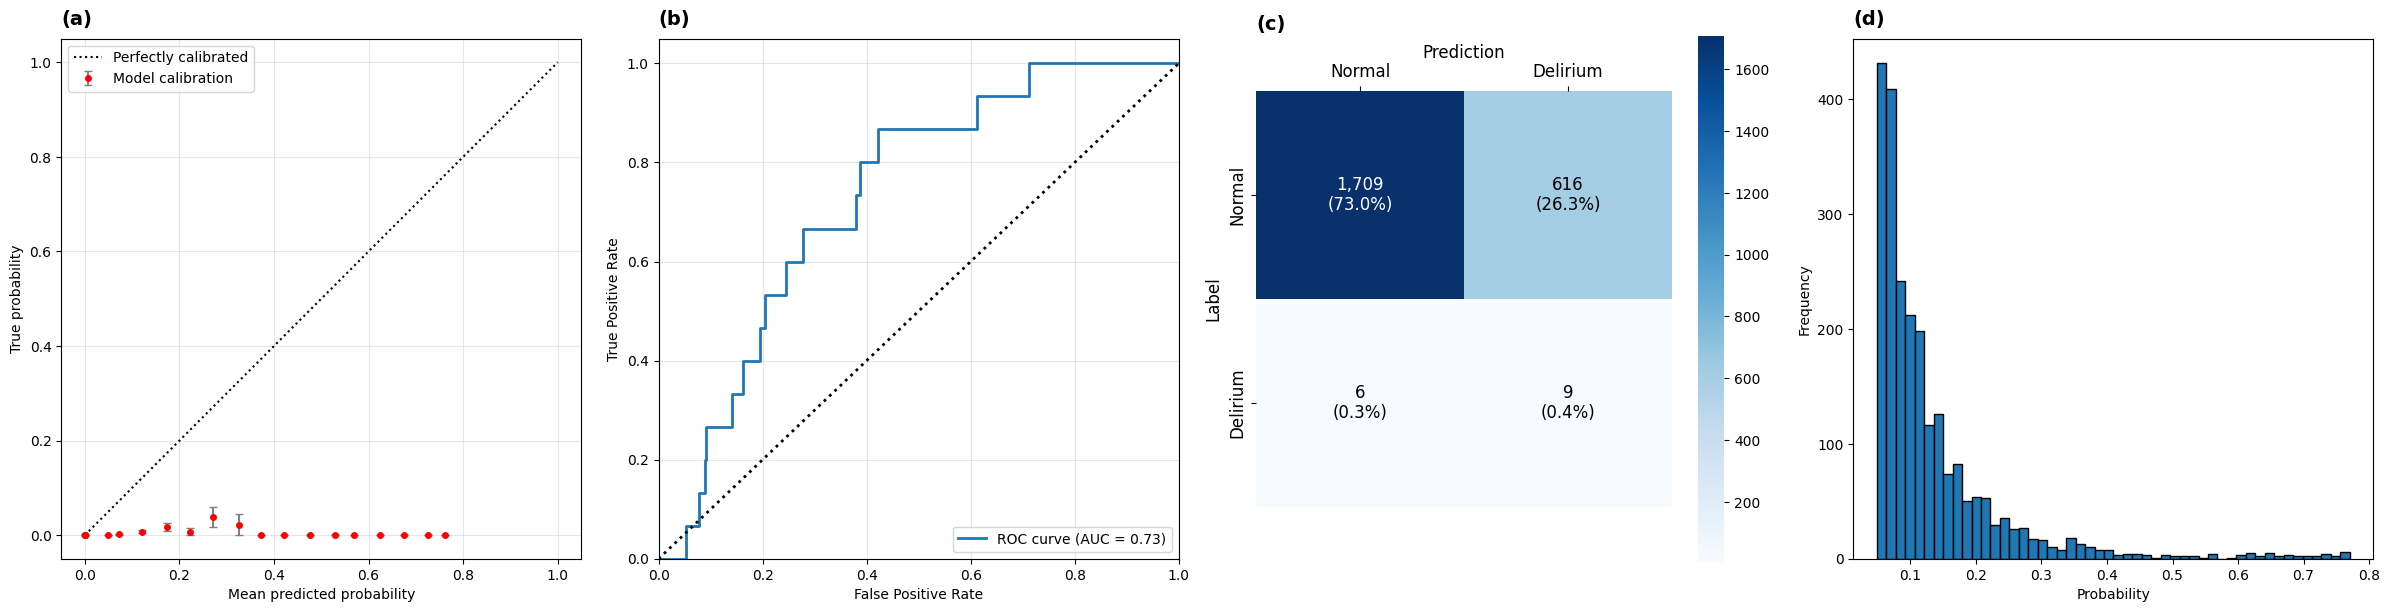

Delong's test P = 0.004, Bootstrap AUPRC t-test P = 0.002

========== Eval for XGB ==========
AUROC 0.801 (95% CI: 0.673-0.891)
AUPRC 0.042 (95% CI: 0.011-0.183)
F1 Score 0.040 (95% CI: 0.019-0.067)
Precision 0.021 (95% CI: 0.009-0.035)
Recall 0.733 (95% CI: 0.471-0.941)
Test Accuracy 0.777 (95% CI: 0.759-0.793)
Brier Score 0.041 (95% CI: 0.037-0.045)
ICI 0.118 (95% CI: 0.112-0.125)


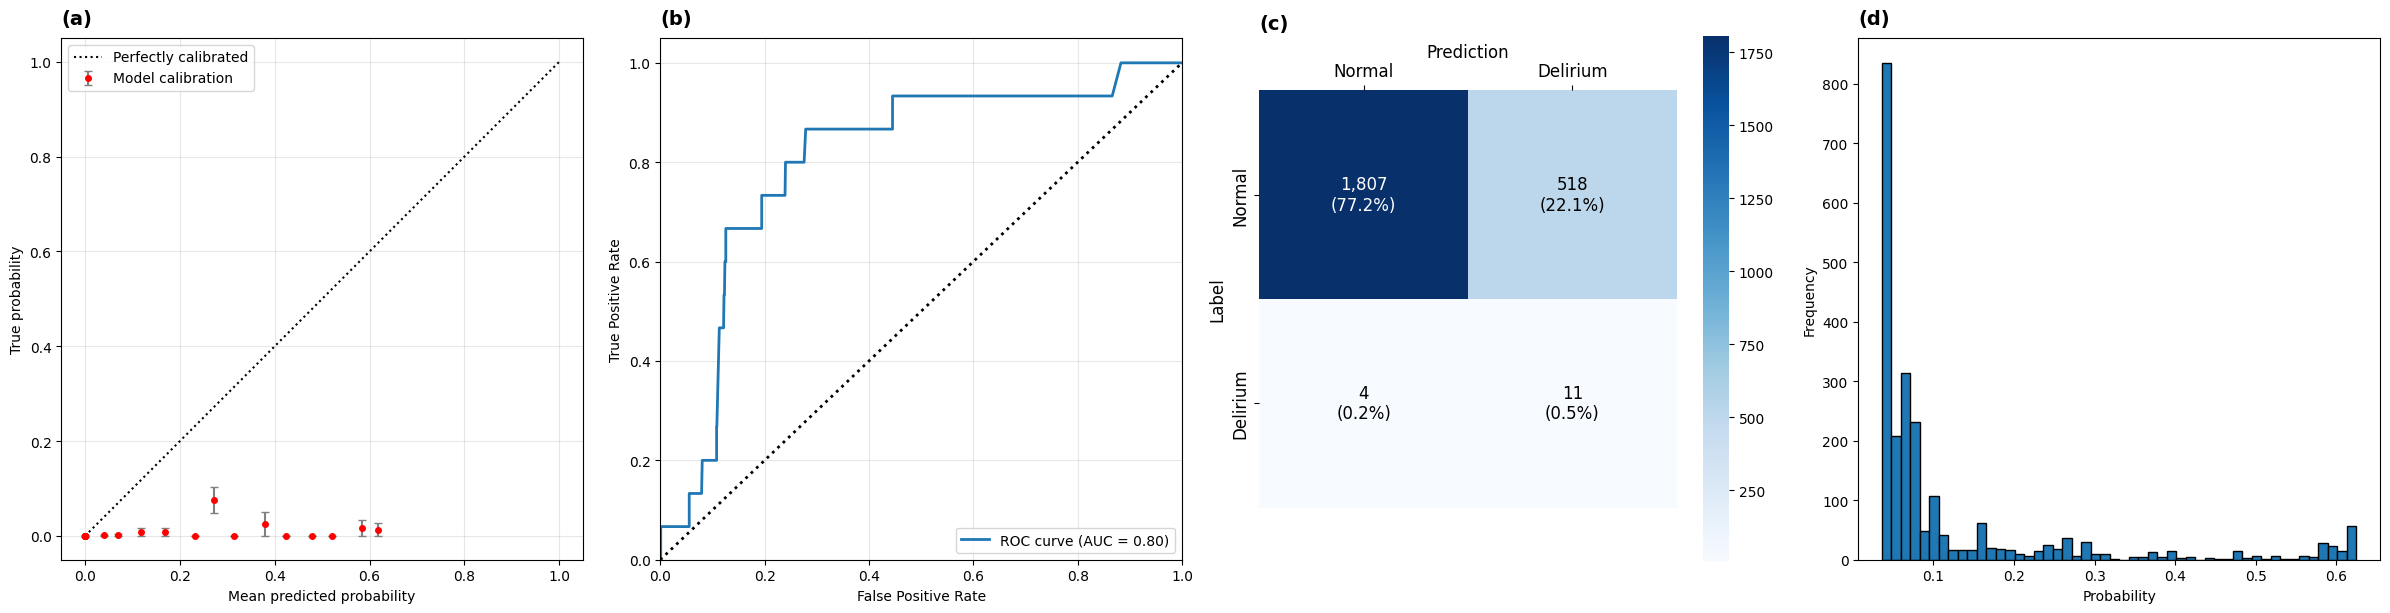

Delong's test P = 0.206, Bootstrap AUPRC t-test P = 0.040


<Figure size 1200x800 with 0 Axes>

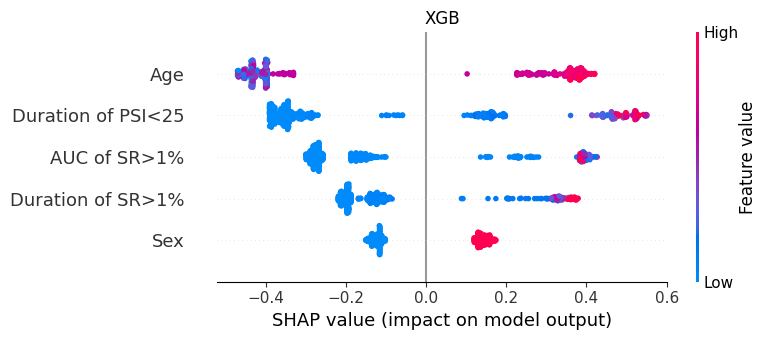


========== Eval for LGB ==========
AUROC 0.798 (95% CI: 0.675-0.890)
AUPRC 0.022 (95% CI: 0.011-0.047)
F1 Score 0.038 (95% CI: 0.017-0.061)
Precision 0.019 (95% CI: 0.009-0.032)
Recall 0.733 (95% CI: 0.467-0.938)
Test Accuracy 0.760 (95% CI: 0.742-0.776)
Brier Score 0.043 (95% CI: 0.038-0.048)
ICI 0.110 (95% CI: 0.103-0.117)


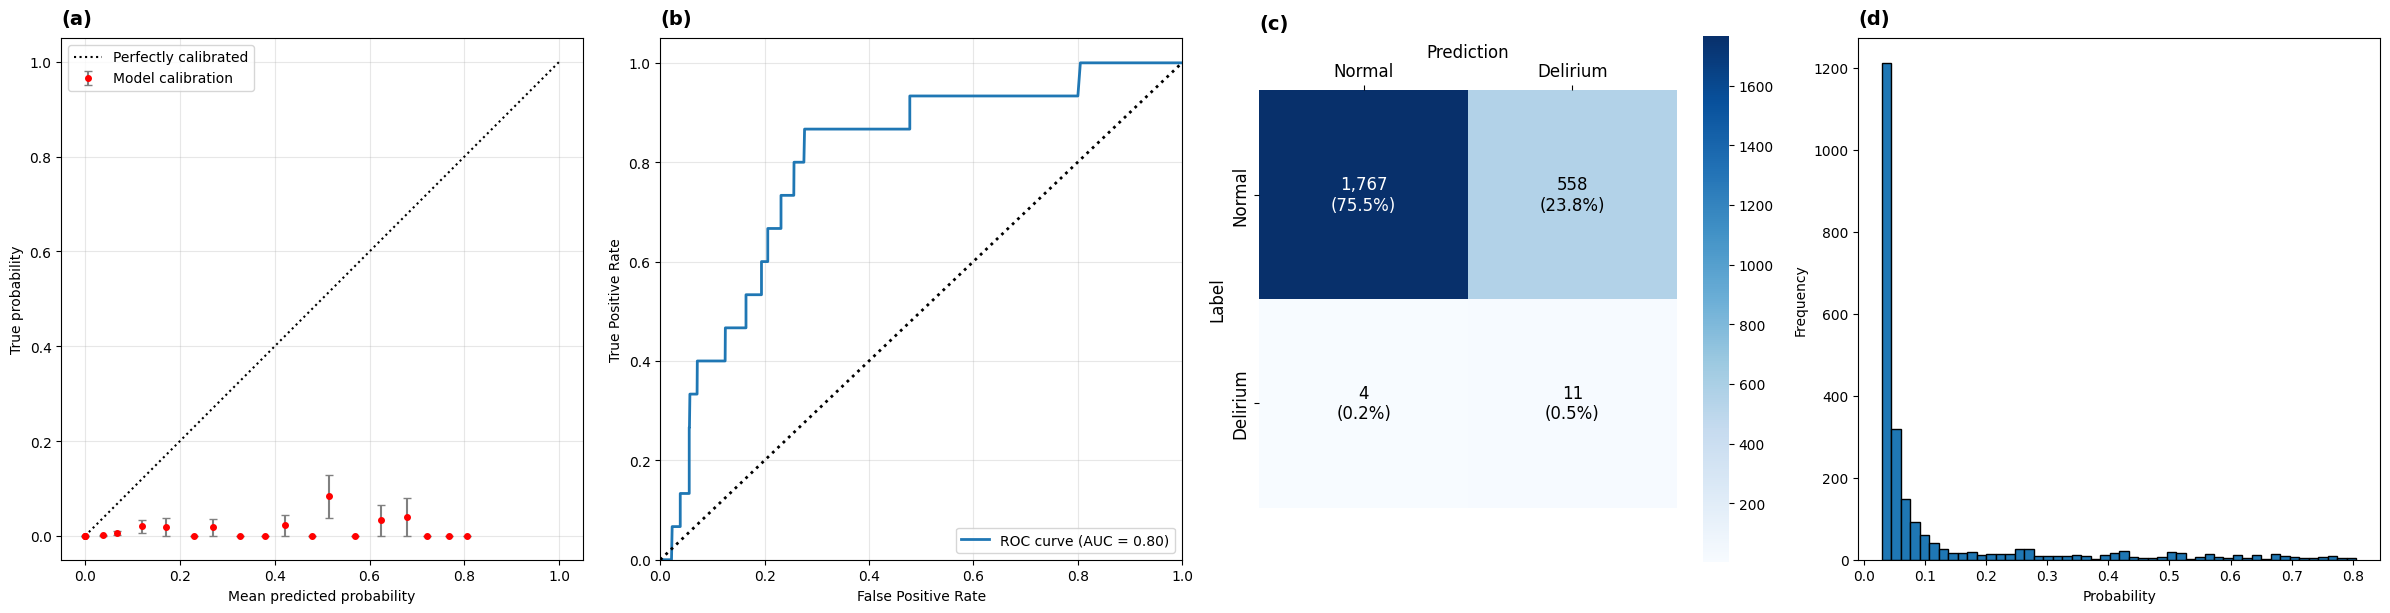

Delong's test P = 0.185, Bootstrap AUPRC t-test P = 0.030


<Figure size 1200x800 with 0 Axes>

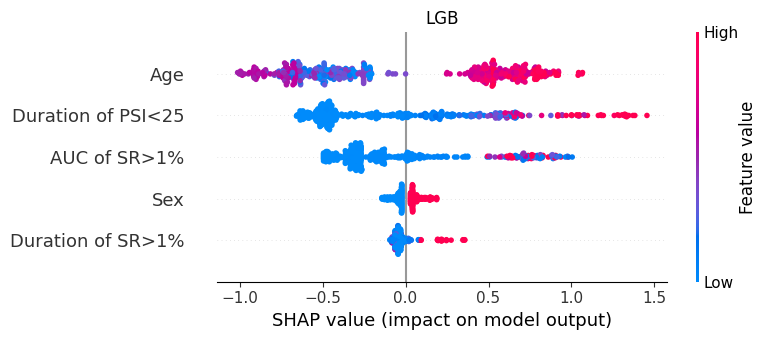


========== Eval for RF ==========
AUROC 0.799 (95% CI: 0.660-0.901)
AUPRC 0.024 (95% CI: 0.011-0.052)
F1 Score 0.045 (95% CI: 0.021-0.075)
Precision 0.023 (95% CI: 0.011-0.039)
Recall 0.733 (95% CI: 0.471-0.941)
Test Accuracy 0.802 (95% CI: 0.786-0.817)
Brier Score 0.042 (95% CI: 0.037-0.048)
ICI 0.100 (95% CI: 0.094-0.108)


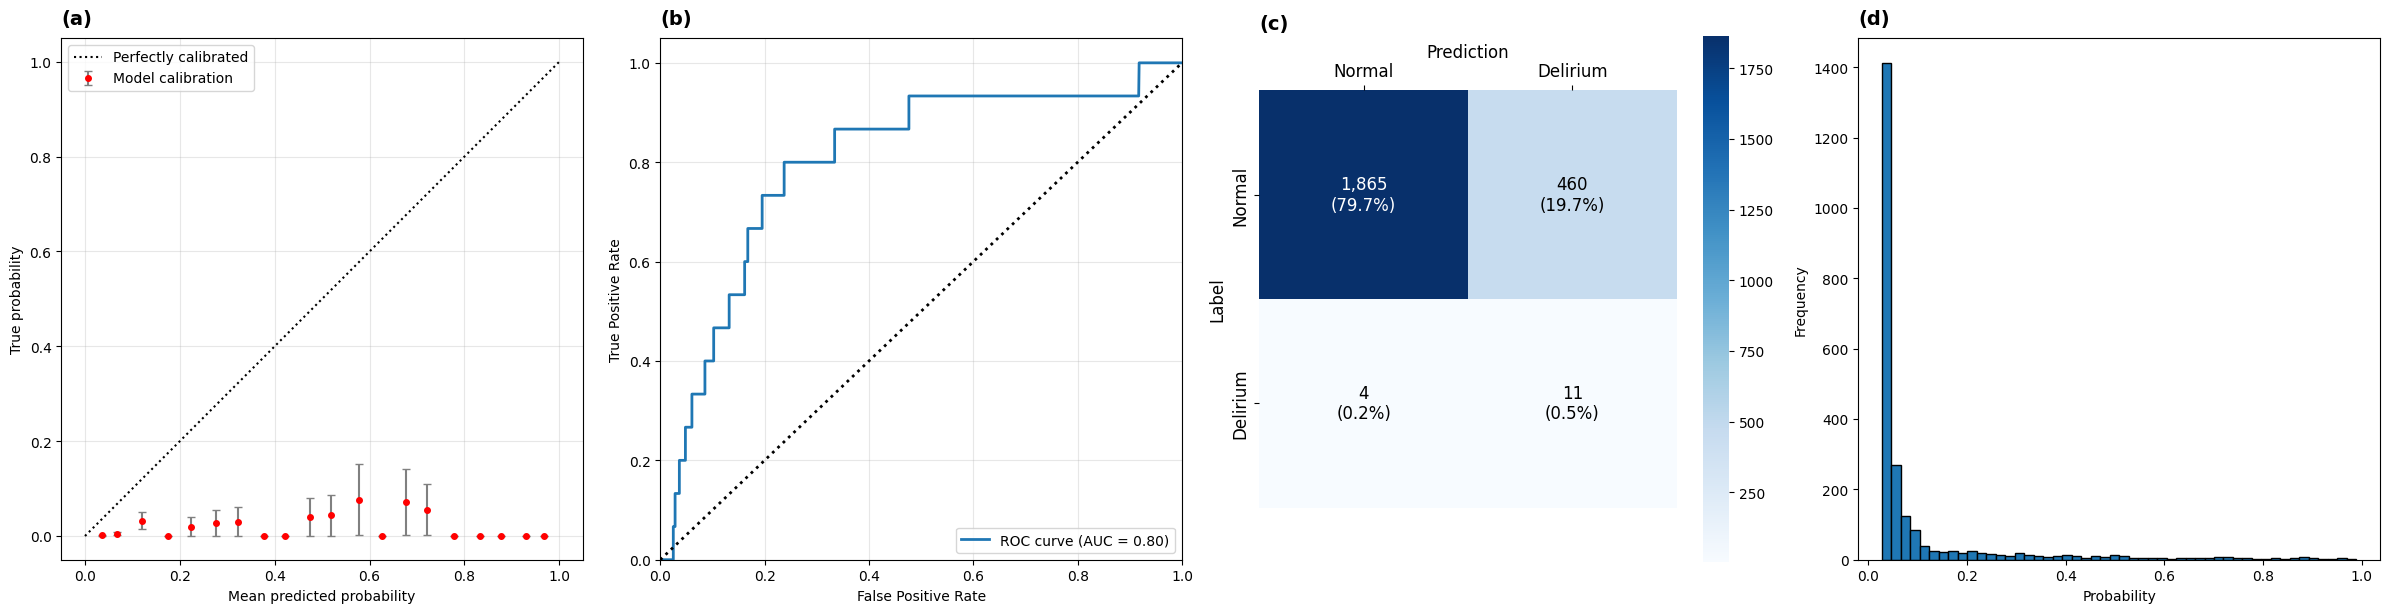

Delong's test P = 0.250, Bootstrap AUPRC t-test P = 0.024


  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

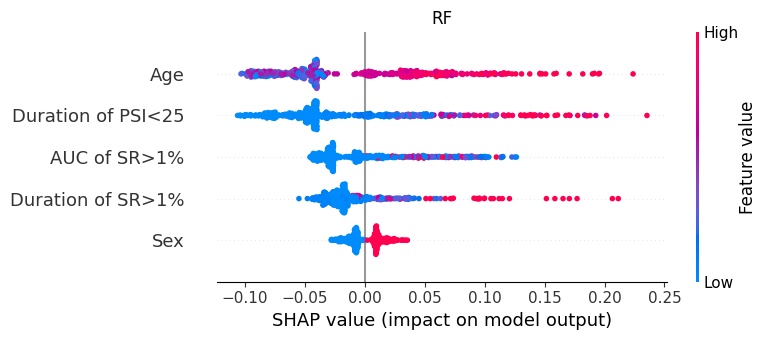


========== Eval for GB ==========
AUROC 0.764 (95% CI: 0.620-0.875)
AUPRC 0.018 (95% CI: 0.009-0.039)
F1 Score 0.046 (95% CI: 0.017-0.080)
Precision 0.024 (95% CI: 0.009-0.043)
Recall 0.533 (95% CI: 0.250-0.786)
Test Accuracy 0.859 (95% CI: 0.844-0.872)
Brier Score 0.052 (95% CI: 0.045-0.059)
ICI 0.082 (95% CI: 0.076-0.092)


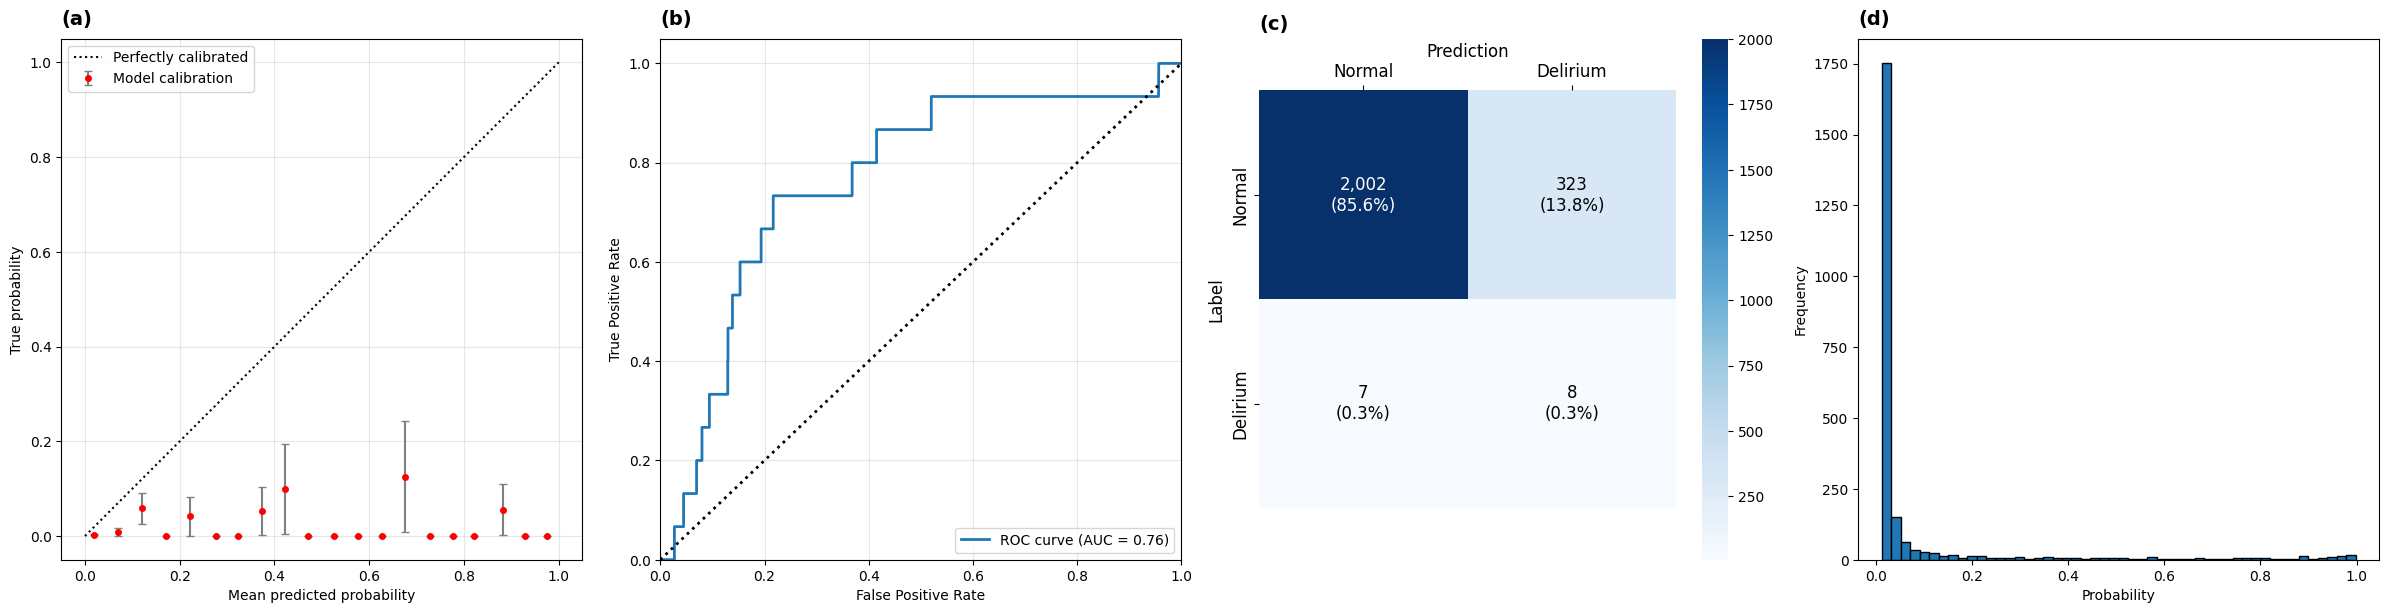

Delong's test P = 0.605, Bootstrap AUPRC t-test P = 0.264


  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

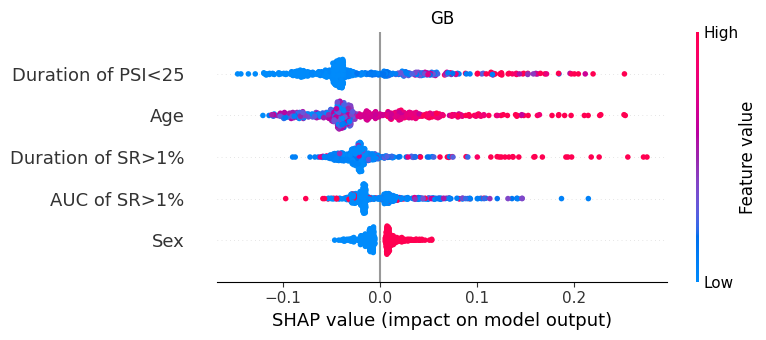

In [14]:
x_train = pd.read_csv('eeg_rid_supreme_train_5_ml.csv')
x_test = pd.read_csv('eeg_rid_supreme_test_ml.csv')
X_train = x_train[features]
y_train = x_train['label']
X_test = x_test[features]
y_test = x_test['label']

lr_model = LogisticRegression(random_state=SEED)
lr_model.fit(X_train, y_train)
x_test['y_test_proba_lr'] = lr_model.predict_proba(X_test)[:, 1]
x_train['y_test_proba_lr'] = lr_model.predict_proba(X_train)[:, 1]
lr_auroc = roc_auc_score(y_test, x_test['y_test_proba_lr'])

trained_models = {}
for model_name, config in model_configs.items():
    with open(f'best_params_{model_name}.json', 'r') as f:
        best_params = json.load(f)
    model = config['class'](**best_params)
    model.fit(X_train, y_train)
    x_test[config['column']] = model.predict_proba(X_test)[:, 1]
    x_train[config['column']] = model.predict_proba(X_train)[:, 1]
    trained_models[model_name] = model

xgb_auroc = roc_auc_score(y_test, x_test['y_test_proba_xgb'])
lgb_auroc = roc_auc_score(y_test, x_test['y_test_proba_lgb'])
rf_auroc = roc_auc_score(y_test, x_test['y_test_proba_rf'])
gb_auroc = roc_auc_score(y_test, x_test['y_test_proba_gb'])
delphi_auroc = roc_auc_score(y_test, x_test['y_test_proba_delphi'])

print(f"DELPHI-EEG AUROC: {delphi_auroc:.3f}, Delong's test P = {delong_roc_test(y_test, x_test['y_test_proba_delphi'], x_test['y_test_proba_lr'])[0][0]:.3f}")

def bootstrap_auprc_test(y_true, y_pred1, y_pred2, n_bootstrap=1000):
    """Bootstrap test for comparing AUPRC between two models"""
    n = len(y_true)
    auprc_diffs = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n, n, replace=True)
        y_boot = y_true[indices]
        pred1_boot = y_pred1[indices]
        pred2_boot = y_pred2[indices]
        
        # Calculate AUPRC for both models
        auprc1 = average_precision_score(y_boot, pred1_boot)
        auprc2 = average_precision_score(y_boot, pred2_boot)
        
        # Store difference
        auprc_diffs.append(auprc1 - auprc2)
    
    # Calculate p-value (two-tailed test)
    auprc_diffs = np.array(auprc_diffs)
    p_value = 2 * min(np.mean(auprc_diffs >= 0), np.mean(auprc_diffs <= 0))
    
    return p_value

y_test = y_test.ravel()
for model_name in ['lr','xgb', 'lgb', 'rf', 'gb']:
    print(f"\n========== Eval for {model_name.upper()} ==========")
    col_name = f'y_test_proba_{model_name}'
    
    Youden = youden(y_train, x_train[col_name])
    calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500, logodds_scale=False)
    calib.fit(x_train[col_name], y_train)
    y_test_proba = x_test[col_name].ravel()
    y_pred_test = (y_test_proba > Youden).astype(int).ravel()
    y_test_proba = calib.calibrate(y_test_proba)
    draw_model_evaluation_plots(y_test, y_test_proba, y_pred_test, n_bins=20)

    if model_name =='lr':
        delong_p = delong_roc_test(y_test, y_test_proba, x_test['y_test_proba_delphi'].ravel())[0][0]
        auprc_p = bootstrap_auprc_test(y_test, y_test_proba, x_test['y_test_proba_delphi'].ravel())
        print(f"Delong's test P = {delong_p:.3f}, Bootstrap AUPRC t-test P = {auprc_p:.3f}")
        continue
    delong_p = delong_roc_test(y_test, y_test_proba, x_test['y_test_proba_lr'].ravel())[0][0]
    auprc_p = bootstrap_auprc_test(y_test, y_test_proba, x_test['y_test_proba_lr'].ravel())
    print(f"Delong's test P = {delong_p:.3f}, Bootstrap AUPRC t-test P = {auprc_p:.3f}")
    model = trained_models[model_name]
    plt.figure(figsize=(12, 8))
    X_test_sample = X_test.sample(n=500, random_state=42)
    if model_name == 'xgb' or model_name == 'lgb':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list):  
            shap_values = shap_values[1]  
    else:
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    plt.figure(figsize=(12, 8))
    X_test_display = X_test_sample.copy()
    feature_name_mapping = {
        'psi_duration': 'Duration of PSI<25',
        'sr_auc': 'AUC of SR>1%',
        'sr_duration': 'Duration of SR>1%',
        'age': 'Age',
        'sex': 'Sex'
    }
    X_test_display = X_test_display.rename(columns=feature_name_mapping)
    shap.summary_plot(shap_values, X_test_display, show=False)
    plt.title(f"{model_name.upper()}")
    plt.tight_layout()
    plt.show()

In [ ]:
x_train = pd.read_csv('eeg_rid_supreme_train_5_ml.csv')
x_test = pd.read_csv('eeg_rid_supreme_test_ml.csv')
X_train = x_train[features]
y_train = x_train['label']
X_test = x_test[features]
y_test = x_test['label']

lr_model = LogisticRegression(random_state=SEED)
lr_model.fit(X_train, y_train)
x_test['y_test_proba_lr'] = lr_model.predict_proba(X_test)[:, 1]
x_train['y_test_proba_lr'] = lr_model.predict_proba(X_train)[:, 1]
lr_auroc = roc_auc_score(y_test, x_test['y_test_proba_lr'])

trained_models = {}
for model_name, config in model_configs.items():
    with open(f'best_params_{model_name}.json', 'r') as f:
        best_params = json.load(f)
    model = config['class'](**best_params)
    model.fit(X_train, y_train)
    x_test[config['column']] = model.predict_proba(X_test)[:, 1]
    x_train[config['column']] = model.predict_proba(X_train)[:, 1]
    trained_models[model_name] = model

def plot_scatter_with_trendline_and_ci_and_stats(x, y, xlabel, ylabel, title=None):
    # Scatter
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x, y, alpha=1, s=3)
    # Fit linear regression
    slope, intercept = np.polyfit(x, y, 1)
    x_vals = np.linspace(np.min(x), np.max(x), 100)
    y_pred = slope * x_vals + intercept

    # Calculate 95% CI for regression line and for slope
    n = len(x)
    y_hat = slope * x + intercept
    mean_x = np.mean(x)
    t_val = stats.t.ppf(0.975, n - 2)
    s_err = np.sqrt(np.sum((y - y_hat) ** 2) / (n - 2))
    confs = t_val * s_err * np.sqrt(1/n + (x_vals - mean_x)**2 / np.sum((x - mean_x)**2))
    upper = y_pred + confs
    lower = y_pred - confs

    # 95% CI for slope
    Sxx = np.sum((x - mean_x) ** 2)
    slope_se = s_err / np.sqrt(Sxx)
    slope_ci = t_val * slope_se

    ax.plot(x_vals, y_pred, color='red', lw=1, label='Linear fit')
    ax.fill_between(x_vals, lower, upper, color='red', alpha=0.2, label='95% CI')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    ax.legend()
    ax.grid(False)
    plt.tight_layout()
    plt.show()
    return slope, intercept, slope_ci

# Scatter plot for sr_dur vs y_test_proba_delphi (inverted axes)
slope_sr_dur, intercept_sr_dur, slope_ci_sr_dur = plot_scatter_with_trendline_and_ci_and_stats(
    x_test['y_test_proba_delphi'].values,
    x_test['sr_duration'].values,
    xlabel='DELPHI-EEG Predicted Probability',
    ylabel='Duration of SR >1%',
    title=None
)

print(f"Intercept: {intercept_sr_dur:.4f}")
print(f"Slope: {slope_sr_dur:.4f} (95% CI: {slope_sr_dur - slope_ci_sr_dur:.4f} to {slope_sr_dur + slope_ci_sr_dur:.4f})")
print()

# Scatter plot for sr_auc vs y_test_proba_delphi (inverted axes)
slope_sr_auc, intercept_sr_auc, slope_ci_sr_auc = plot_scatter_with_trendline_and_ci_and_stats(
    x_test['y_test_proba_delphi'].values,
    x_test['sr_auc'].values,
    xlabel='DELPHI-EEG Predicted Probability',
    ylabel='AUC of SR >1%',
    title=None
)

print("Spearman's correlation for sr_auc vs y_test_proba_delphi:")
print(f"  Intercept: {intercept_sr_auc:.4f}")
print(f"  Slope: {slope_sr_auc:.4f} (95% CI: {slope_sr_auc - slope_ci_sr_auc:.4f} to {slope_sr_auc + slope_ci_sr_auc:.4f})")
print()

## Statistics/ Explainability

In [ ]:
FILE= np.load('F_f.npy', mmap_mode='r')
GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')
general_mask = (GENERAL == 1)
FILE = np.unique(FILE[general_mask])

x1 = pd.read_csv('eeg_rid_supreme_labelled_raw.csv') # label, exclude, p,c
x1['label']= ((x1['label_p']==1)|(x1['label_c']==1)).astype(int)
x1['exclude']=((x1['exclude_p']==1)|(x1['exclude_c']==1)).astype(int)
x1['exclude_both']= ((x1['exclude_p']==1)&(x1['exclude_c']==1)).astype(int)

x2 = pd.read_csv('eeg_rid_supreme_labelled.csv')

print(f"====Eligible Criteria: {x1['label'].value_counts().sum()}")
print(x1['label'].value_counts())
print()
print(f"====Exclusion:{x1['exclude'].value_counts()[1]}")
print(f"Preoperative anti-psychotics:{x1['exclude_p'].value_counts()[1]-x1['exclude_both'].value_counts()[1]}")
print(f"Preoperative NP consultion:{x1['exclude_c'].value_counts()[1]-x1['exclude_both'].value_counts()[1]}")
print(f"Both:{x1['exclude_both'].value_counts()[1]}")
print()
print(f'====Final labels: {x2["label"].value_counts().sum()}')
print(x2['label'].value_counts())
print()

with open('train_files.pkl', 'rb') as f:
    train_files = pickle.load(f)
x2_d_1 = x2[x2['filename'].isin(train_files)]
print(f"====Initial development set: {x2_d_1['label'].value_counts().sum()}")
print(x2_d_1['label'].value_counts())
print(f"====Undersampled development set")
x2_d_2 = pd.read_csv('eeg_rid_supreme_train_5.csv')
x2_d_2 = x2_d_2[x2_d_2['filename'].isin(FILE)]
print(x2_d_2['label'].value_counts())
print(f"(+) samples: {x2_d_2.loc[x2_d_2['label']==1]['filename'].nunique()*30}")
print(f"(-) samples: {x2_d_2.loc[x2_d_2['label']==0]['filename'].nunique()*30}")
F_f = np.load('F_f.npy', allow_pickle=True)
print(f"====Development set")
mask = np.isin(F_f, x2_d_2.loc[x2_d_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_d_2.loc[x2_d_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print()

with open('test_files.pkl', 'rb') as f:
    test_files = pickle.load(f)
x2_t_1 = x2[x2['filename'].isin(test_files)]
print(f"====Test set:{x2_t_1['label'].value_counts().sum()}")
print(x2_t_1['label'].value_counts())
print(f"(+) samples: {x2_t_1['label'].value_counts()[1]*30}")
print(f"(-) samples: {x2_t_1['label'].value_counts()[0]*30}")
x2_t_2 = pd.read_csv('eeg_rid_supreme_test.csv')
x2_t_2 = x2_t_2[x2_t_2['filename'].isin(FILE)]
print("====Original ratio test set")
mask = np.isin(F_f, x2_t_2.loc[x2_t_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_t_2.loc[x2_t_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print("====1:1 Undersampled test set")
test_ids_1 = np.load("test_ids_1.npy", allow_pickle=True)
x2_t_3 = x2_t_2[x2_t_2['hid'].isin(test_ids_1)]
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print("====2:1 Undersampled test set")
test_ids_1 = np.load("test_ids_2.npy", allow_pickle=True)
x2_t_3 = x2_t_2[x2_t_2['hid'].isin(test_ids_1)]
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print()
x = pd.read_csv('eeg_rid_supreme_test.csv')
x = x[x['filename'].isin(FILE)]
F_f = np.load('F_f.npy', allow_pickle=True)
x = x[x['filename'].isin(F_f)]
print(f"hid ratio of original ratio test set {x.loc[x['label']==0, 'hid'].nunique()/x.loc[x['label']==1, 'hid'].nunique():.0f}:1")

In [ ]:
x= pd.read_csv('eeg_rid_supreme_labelled.csv') #x['filename']
x2= pd.read_csv('delirium_old.csv', encoding='cp949', encoding_errors='ignore')
sex_mapping = dict(zip(x2['연구별 환자 ID'], x2['성별']))
x['sex'] = x['hid'].map(sex_mapping)
x['sex'] = x['sex'].map({'M': 1, 'F': 0})
with open('test_files.pkl', 'rb') as f:
    test_files = pickle.load(f)

# Overall statistics
age_mean = x['age'].mean()
age_std = x['age'].std()
plt.figure(figsize=(10, 6))
plt.hist(x['age'], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of Age (Mean: {age_mean:.2f}, Std: {age_std:.2f})')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()
print(f"Overall - Mean age: {age_mean:.2f}")
print(f"Overall - Standard deviation of age: {age_std:.2f}")
print(f"Overall - Proportion of male: {x['sex'].value_counts()[1]*100/x['sex'].value_counts().sum():.1f}%")
print()

# Test set statistics
x_test = x[x['filename'].isin(test_files)]
test_age_mean = x_test['age'].mean()
test_age_std = x_test['age'].std()
test_male_prop = x_test['sex'].value_counts()[1]*100/x_test['sex'].value_counts().sum()
print(f"Test set - Mean age: {test_age_mean:.2f}")
print(f"Test set - Standard deviation of age: {test_age_std:.2f}")
print(f"Test set - Proportion of male: {test_male_prop:.1f}%")
print()

# Non-test set statistics
x_non_test = x[~x['filename'].isin(test_files)]
non_test_age_mean = x_non_test['age'].mean()
non_test_age_std = x_non_test['age'].std()
non_test_male_prop = x_non_test['sex'].value_counts()[1]*100/x_non_test['sex'].value_counts().sum()
print(f"Non-test set - Mean age: {non_test_age_mean:.2f}")
print(f"Non-test set - Standard deviation of age: {non_test_age_std:.2f}")
print(f"Non-test set - Proportion of male: {non_test_male_prop:.1f}%")

In [ ]:
x = pd.read_csv('eeg_rid_supreme_labelled.csv')

x['interval'] = x[['label_p_interval','label_c_interval']].min(axis=1)
interval_stats = x['interval'].describe()
print("Statistics of interval:")
print(interval_stats)
plt.figure(figsize=(10, 6))
plt.hist(x['interval'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Histogram of Interval Values')
plt.xlabel('Interval')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
set_seeds()
run_frequency_analysis(
    model_path='final_model_full_training.pth',
    test_file='test_ids.npy',
)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')
general_mask = (GENERAL == 1)

X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]

youden_threshold = np.load('youden.npy')
with open('calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

test_file = 'test_ids.npy'
test_ids = np.load(test_file, allow_pickle=True)
test_mask = np.isin(ID, test_ids)
X_test = X_normalized[test_mask] 
y_test = Y_normalized[test_mask]
a_test = A[test_mask]
s_test = S[test_mask]
p_test = P[test_mask].copy()
file_ids_test = FILE[test_mask]
del X_normalized, ID, A, S, Y_normalized, test_ids, test_mask
clear_memory()
test_dataset = ChunkedDataset(X_test, a_test, s_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH)
checkpoint = torch.load('final_model_full_training.pth', map_location=device)
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

print("Evaluating baseline model performance...")
baseline_f1 = evaluate_model(model, test_loader, device, youden_threshold, calib)
print(f"Baseline F1 for POD: {baseline_f1:.3f}")
# Parameters for FFT
fs = 80  # Sampling rate of 80 Hz (based on your SEGLEN = 120*80)
n_fft = 16384  # Increased FFT size to accommodate the larger input (power of 2 for efficiency)
# Define frequency bands for perturbation
frequency_bands = {
    'Slow (0.5-1 Hz)': (0.5, 1),
    'Delta (1-4 Hz)': (1, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-12 Hz)': (8, 12),
    'Beta (12-30 Hz)': (12, 30)
}
# Frequency band ablation on the original time series
# Store results for frequency band ablation
frequency_band_results = []
# Calculate frequency axis (in Hz)
freq_axis = np.fft.fftfreq(n_fft, 1/fs)[:n_fft//2]
# For each frequency band, create a copy of the model and zero out that band in the input data
for band_name, (low_freq, high_freq) in frequency_bands.items():
    print(f"Ablating {band_name} band ({low_freq}-{high_freq} Hz)")
    # Create a modified test dataset with the frequency band ablated
    X_test_modified = X_test.copy()
    # Get the frequency indices corresponding to this band
    low_idx = np.where(freq_axis >= low_freq)[0][0]
    high_idx = np.where(freq_axis <= high_freq)[0][-1]
    # Apply FFT to each channel of each sample, zero out the specified band, and convert back
    for i in tqdm(range(len(X_test_modified))):
        for channel in range(X_test_modified.shape[1]):
            # Get the channel data
            channel_data = X_test_modified[i, channel, :]
            # Apply window function (Hanning) to reduce spectral leakage
            windowed_data = channel_data * np.hanning(len(channel_data))
            # Zero-pad to n_fft points - make sure n_fft is larger than channel_data length
            padded_data = np.zeros(n_fft)
            padded_data[:len(channel_data)] = windowed_data
            # Compute FFT
            data_fft = fft(padded_data)
            # Create a mask that zeros out the specified frequency band
            mask = np.ones_like(data_fft)
            mask[low_idx:high_idx+1] = 0
            mask[n_fft-high_idx-1:n_fft-low_idx] = 0  # Mirror for negative frequencies
            # Apply the mask to the frequency response
            modified_fft = data_fft * mask
            # Convert back to time domain (inverse FFT)
            modified_data = np.real(ifft(modified_fft))
            # Update the data
            X_test_modified[i, channel, :] = modified_data[:len(channel_data)]
            # Free up memory for temporary arrays
            del channel_data, windowed_data, padded_data, data_fft, mask, modified_fft, modified_data
    # Create a new dataset and loader with the modified data
    modified_test_dataset = ChunkedDataset(X_test_modified, a_test, s_test, y_test)
    modified_test_loader = DataLoader(modified_test_dataset, batch_size=BATCH)
    # Evaluate the model with the modified data
    band_ablated_f1 = evaluate_model(model, modified_test_loader, device, youden_threshold, calib)
    # Calculate percent change in performance
    f1_change = ((band_ablated_f1 - baseline_f1) / baseline_f1) * 100
    print(f"F1 for POD: {band_ablated_f1:.3f} (Change: {f1_change:.3f}%)")
    # Store results
    frequency_band_results.append({
        'band_name': band_name,
        'f1_change': f1_change
    })
    # Clean up memory after each loop
    del X_test_modified, modified_test_dataset, modified_test_loader, band_ablated_f1, f1_change
    import gc
    gc.collect()
    if 'torch' in globals():
        if hasattr(torch, 'cuda') and torch.cuda.is_available():
            torch.cuda.empty_cache()

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.grid': False
})

# Define frequency bands for perturbation
frequency_bands = {
    'Slow (0.5–1 Hz)': (0.5, 1),
    'Delta (1–4 Hz)': (1, 4),
    'Theta (4–8 Hz)': (4, 8),
    'Alpha (8–12 Hz)': (8, 12),
    'Beta (12–30 Hz)': (12, 30)
}

# Visualize results
plt.figure(figsize=(6, 4))  
band_names = list(frequency_bands.keys())
f1_changes = [result['f1_change'] for result in frequency_band_results]
changes = [-f1_change for f1_change in f1_changes]
bars = plt.bar(range(len(band_names)), changes, color='skyblue', edgecolor='black')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xticks(range(len(band_names)), band_names, rotation=45, ha='right')
plt.ylabel('ΔF1 Score for POD (%)')
plt.xlabel('Frequency Band')
plt.tight_layout()
plt.show()

In [41]:
# Extract DEPT, TIVA
x1 = pd.read_csv('eeg_rid_supreme_labelled.csv')
x2 = pd.read_csv('op_ane_type.csv')
x2 = x2.loc[(x2['마취종류']!='국소')]
if 'Vital DB 파일 경로' in x2.columns:
    x2['vital'] = (
        x2['Vital DB 파일 경로']
        .astype(str)
        .str.split('/')
        .str[-1]
        .str.replace('.vital', '', regex=False)
    )

x1['dtend'] = pd.to_datetime(x1['dtend'], errors='coerce').dt.date
x2 = x2.rename(columns={'연구별 환자 ID': 'hid'})
x1['dtstart'] = pd.to_datetime(x1['dtstart']).dt.strftime('%Y-%m-%d')
x1['dtend'] = (pd.to_datetime(x1['dtstart'])+pd.DateOffset(days=1)).dt.strftime('%Y-%m-%d')
x1['dtprior']= (pd.to_datetime(x1['dtstart'])-pd.DateOffset(days=1)).dt.strftime('%Y-%m-%d')
if '수술시작일시' in x2.columns:
    x2['수술시작일시'] = pd.to_datetime(x2['수술시작일시']).dt.strftime('%Y-%m-%d')

x1['hid_dtstart'] = x1['hid'].astype(str) + '_' + x1['dtstart'].astype(str)
x1['hid_dtend'] = x1['hid'].astype(str) + '_' + x1['dtend'].astype(str)
x1['hid_dtprior'] = x1['hid'].astype(str) + '_' + x1['dtprior'].astype(str)
x2['hid_dtstart'] = x2['hid'].astype(str) + '_' + x2['수술시작일시'].astype(str)


if 'vital' in x2.columns and 'filename' in x1.columns:
    x2_vital_unique = x2.drop_duplicates(subset=['vital'])
    for col in ['수술명', '마취기록', '수술진료과코드', '마취종류']:
        mapped = x1['filename'].map(x2_vital_unique.set_index('vital')[col])
        x1[col] = mapped

mask_blank = x1['수술명'].isna() | (x1['수술명'] == '')
x2_unique = x2.drop_duplicates(subset=['hid_dtstart'])
for col in ['수술명', '마취기록', '수술진료과코드', '마취종류']:
    mapped = x1.loc[mask_blank, 'hid_dtstart'].map(x2_unique.set_index('hid_dtstart')[col])
    x1.loc[mask_blank, col] = x1.loc[mask_blank, col].combine_first(mapped)

mask_blank = x1['수술명'].isna() | (x1['수술명'] == '')
x2_unique_dtend = x2.drop_duplicates(subset=['hid_dtstart'])
for col in ['수술명', '마취기록', '수술진료과코드', '마취종류']:
    mapped = x1.loc[mask_blank, 'hid_dtend'].map(x2_unique_dtend.set_index('hid_dtstart')[col])
    x1.loc[mask_blank, col] = x1.loc[mask_blank, col].combine_first(mapped)

mask_blank = x1['수술명'].isna() | (x1['수술명'] == '')
x2_unique_dtprior = x2.drop_duplicates(subset=['hid_dtstart'])
for col in ['수술명', '마취기록', '수술진료과코드', '마취종류']:
    mapped = x1.loc[mask_blank, 'hid_dtprior'].map(x2_unique_dtprior.set_index('hid_dtstart')[col])
    x1.loc[mask_blank, col] = x1.loc[mask_blank, col].combine_first(mapped)

x1['TIVA'] = x1['마취기록'].str.contains('TIVA|TCI', case=False, na=False).astype(int)

replace_map = {
    'POT': 'OT', 'PTS': 'TS', 'PNS': 'NS', 'POS': 'OS', 'PDS': 'GS', 'PUR': 'UR', 'PPS': 'PS',
    'GSO1': 'GS', 'GAGS': 'GS', 'GIS': 'GS', 'NP': 'GS', 'TCGS': 'GS', 'BCCGS': 'GS', 'OTS': 'GS',
    'CRS': 'GS', 'HBPS': 'GS', 'LUTS': 'TS', 'ROCTR': 'TS', 'GYCOG': 'OG', 'DR': 'Others',
    'DM': 'Others', 'TRC': 'Others', 'IMR': 'Others', 'IMH': 'Others', 'MTR': 'Others', 'RH': 'Others',
    'IMN': 'Others', 'IMG': 'Others', 'NUGDW': 'Others', 'TR': 'Others', 'IM': 'Others', 'OthersS': 'Others',
    'PS': 'Others', 'OL': 'Others', 'TVS': 'TS', 'BEN': 'GS'
}

def map_dept(code):
    code = str(code)
    # First, apply direct replacements
    for k, v in replace_map.items():
        if k in code:
            code = code.replace(k, v)
    # Special handling for 'UR' or 'OG' together
    if 'UR' in code and 'OG' in code:
        code = 'UR+OG'
    # Map 'UR+OG' and 'GS'
    if code == 'UR+OG' or code == 'GS':
        code = 'Abdominopelvic'
    elif code == 'OS':
        code = 'Others'
    elif code == 'TS':
        code = 'Thoracic'
    elif code == 'GS':
        code = 'Abdominopelvic'
    return code

x1['dept'] = x1['수술진료과코드'].apply(map_dept)
x1['interval'] = x1[['label_p_interval','label_c_interval']].min(axis=1)

FILE = np.load('F_f.npy', mmap_mode='r')

filename_to_dept = x1.set_index('filename')['dept'].to_dict()
filename_to_tiva = x1.set_index('filename')['TIVA'].to_dict()
filename_to_interval = x1.set_index('filename')['interval'].to_dict()
filename_to_ane_type = x1.set_index('filename')['마취종류'].to_dict()

DEPT = np.array([filename_to_dept.get(f, np.nan) for f in FILE])
TIVA = np.array([filename_to_tiva.get(f, np.nan) for f in FILE])
INTERVAL = np.array([filename_to_interval.get(f, np.nan) for f in FILE])
GENERAL = np.array([1 if filename_to_ane_type.get(f, None) == '전신' else 0 for f in FILE])

np.save('DEPT_f.npy', DEPT)
np.save('TIVA_f.npy', TIVA)
np.save('INTERVAL_f.npy', INTERVAL)
np.save('GENERAL_f.npy', GENERAL)


In [ ]:
# Subgroup Analysis
X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')
DEPT = np.load('DEPT_f.npy', mmap_mode='r')
TIVA = np.load('TIVA_f.npy', mmap_mode='r')

GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')
general_mask = (GENERAL == 1)

X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]
DEPT = DEPT[general_mask]
TIVA = TIVA[general_mask]

with open('calibration.pkl', 'rb') as f:
    calib = pickle.load(f)
Youden = np.load('youden.npy').item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedGCNCNN(adj=adj).to(device)
models = []
checkpoint = torch.load(f'final_model_full_training.pth')
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
models.append(model)

test_ids_file = 'test_ids.npy'
test_ids = np.load(test_ids_file, allow_pickle=True)
test_mask = np.isin(ID, test_ids)
X_test = X_normalized[test_mask] 
y_test = Y_normalized[test_mask]
a_test = A[test_mask]
s_test = S[test_mask]
p_test = P[test_mask].copy()
file_test = FILE[test_mask]
dept_test = DEPT[test_mask]
tiva_test = TIVA[test_mask]

# Define subgroups
subgroups = [
    ("TIVA=1", lambda: tiva_test == 1),
    ("TIVA=0", lambda: tiva_test == 0),
    ("DEPT=Abdominopelvic", lambda: (dept_test == 'Abdominopelvic') | (dept_test == 'OG') | (dept_test == 'UR')),
    ("DEPT=Thoracic", lambda: dept_test == 'Thoracic'),
    ("DEPT=Others", lambda: dept_test == 'Others'),
]

for subgroup_name, subgroup_mask_fn in subgroups:
    print(f"\n=== Subgroup: {subgroup_name} ===")
    mask = subgroup_mask_fn()
    if np.sum(mask) == 0:
        print(f"No samples in subgroup {subgroup_name}. Skipping.")
        continue

    X_sub = X_test[mask]
    y_sub = y_test[mask]
    a_sub = a_test[mask]
    s_sub = s_test[mask]
    p_sub = p_test[mask].copy()
    file_sub = file_test[mask]

    test_dataset = ChunkedDataset(X_sub, a_sub, s_sub, y_sub)
    test_loader = DataLoader(test_dataset, batch_size=BATCH)
    del test_dataset

    test_label_0 = np.sum(y_sub[:, None] == 0)
    test_label_1 = np.sum(y_sub[:, None] == 1)
    print(f"Subgroup test set - Label 0: {test_label_0}, Label 1: {test_label_1}")

    test_preds_all_models = []
    test_targets = []

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'[Test][{subgroup_name}]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            batch_preds = []
            for model in models:
                model.eval()
                outputs = model(inputs, age, sex, adj)
                batch_preds.append(outputs.detach().cpu().numpy())
            test_preds_all_models.extend(batch_preds[0].ravel())
            test_targets.extend(targets.detach().cpu().numpy())
    test_preds = np.array(test_preds_all_models)
    test_targets = np.array(test_targets)

    valid_indices = ~np.isnan(p_sub)
    filtered_test_preds = test_preds[valid_indices]
    filtered_p_test = p_sub[valid_indices]
    test_ids_expanded = file_sub
    test_preds = calib.calibrate(test_preds)
    unique_test_ids = np.unique(test_ids_expanded)
    averaged_test_preds = []
    averaged_test_targets = []
    averaged_p_test = []

    for test_id in unique_test_ids:
        id_indices = np.where(test_ids_expanded == test_id)[0]
        if len(id_indices) > 0:
            id_preds = test_preds[id_indices]
            id_p_test = p_sub[id_indices]
            averaged_test_preds.append(np.mean(id_preds))
            averaged_p_test.append(np.nanmean(id_p_test))
            averaged_test_targets.append(test_targets[id_indices[0]])

    y_test_sub = np.array(averaged_test_targets).ravel()
    y_test_proba_sub = np.array(averaged_test_preds)
    p_test_mean_sub = np.array(averaged_p_test)
    valid_indices = ~np.isnan(p_test_mean_sub)
    filtered_y_test_proba = y_test_proba_sub[valid_indices]
    filtered_y_test = y_test_sub[valid_indices]
    filtered_y_pred_test = (filtered_y_test_proba > Youden).astype(int)
    draw_model_evaluation_plots(filtered_y_test, filtered_y_test_proba, filtered_y_pred_test, n_bins=20, n_bootstraps=100)
    torch.cuda.empty_cache()
    gc.collect()
    del test_loader

In [ ]:
# Survival analysis
X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')
INTERVAL = np.load('INTERVAL_f.npy', mmap_mode='r')

GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')
general_mask = (GENERAL == 1)

X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]
INTERVAL = INTERVAL[general_mask]

with open('calibration.pkl', 'rb') as f:
    calib = pickle.load(f)
Youden = np.load('youden.npy').item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedGCNCNN(adj=adj).to(device)
models = []
checkpoint = torch.load(f'final_model_full_training.pth')
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
models.append(model)

test_ids_file = 'test_ids.npy'
test_ids = np.load(test_ids_file, allow_pickle=True)
test_mask = np.isin(ID, test_ids)
X_test = X_normalized[test_mask] 
y_test = Y_normalized[test_mask]
a_test = A[test_mask]
s_test = S[test_mask]
p_test = P[test_mask].copy()
file_test = FILE[test_mask]
interval_test = INTERVAL[test_mask]

X_sub = X_test
y_sub = y_test
a_sub = a_test
s_sub = s_test
p_sub = p_test.copy()
file_sub = file_test
interval_sub = interval_test

test_dataset = ChunkedDataset(X_sub, a_sub, s_sub, y_sub)
test_loader = DataLoader(test_dataset, batch_size=BATCH)
del test_dataset

test_label_0 = np.sum(y_sub[:, None] == 0)
test_label_1 = np.sum(y_sub[:, None] == 1)
print(f"Test set - Label 0: {test_label_0}, Label 1: {test_label_1}")

test_preds_all_models = []
test_targets = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc=f'[Test]')
    for inputs, age, sex, targets in test_pbar:
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        batch_preds = []
        for model in models:
            model.eval()
            outputs = model(inputs, age, sex, adj)
            batch_preds.append(outputs.detach().cpu().numpy())
        test_preds_all_models.extend(batch_preds[0].ravel())
        test_targets.extend(targets.detach().cpu().numpy())
test_preds = np.array(test_preds_all_models)
test_targets = np.array(test_targets)

valid_indices = ~np.isnan(p_sub)
filtered_test_preds = test_preds[valid_indices]
filtered_p_test = p_sub[valid_indices]
filtered_interval = interval_sub[valid_indices]
test_ids_expanded = file_sub
test_preds = calib.calibrate(test_preds)
unique_test_ids = np.unique(test_ids_expanded)
averaged_test_preds = []
averaged_test_targets = []
averaged_p_test = []
averaged_interval = []

for test_id in unique_test_ids:
    id_indices = np.where(test_ids_expanded == test_id)[0]
    if len(id_indices) > 0:
        id_preds = test_preds[id_indices]
        id_p_test = p_sub[id_indices]
        id_interval = interval_sub[id_indices]
        averaged_test_preds.append(np.mean(id_preds))
        averaged_p_test.append(np.nanmean(id_p_test))
        averaged_test_targets.append(test_targets[id_indices[0]])
        averaged_interval.append(np.nanmean(id_interval))

y_test_sub = np.array(averaged_test_targets).ravel()
y_test_proba_sub = np.array(averaged_test_preds)
p_test_mean_sub = np.array(averaged_p_test)
interval_mean_sub = np.array(averaged_interval)
valid_indices = ~np.isnan(p_test_mean_sub)
filtered_y_test_proba = y_test_proba_sub[valid_indices]
filtered_y_test = y_test_sub[valid_indices]
filtered_y_pred_test = (filtered_y_test_proba > Youden).astype(int)
filtered_interval = interval_mean_sub[valid_indices]
torch.cuda.empty_cache()
gc.collect()
del test_loader

group_0_mask = filtered_y_pred_test == 0
group_1_mask = filtered_y_pred_test == 1
T0_raw = filtered_interval[group_0_mask]
T1_raw = filtered_interval[group_1_mask]
def process_survival_arrays(T):
    max_time = np.nanmax(filtered_interval)
    event_observed = ~np.isnan(T)
    durations = np.where(np.isnan(T), max_time, T)
    return durations, event_observed.astype(int)
T0, E0 = process_survival_arrays(T0_raw)
T1, E1 = process_survival_arrays(T1_raw)
kmf0 = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()
plt.figure(figsize=(8,6))
kmf0.fit(T0, event_observed=E0, label='Predicted POD-Negative')
kmf1.fit(T1, event_observed=E1, label='Predicted POD-Positive')
ax = kmf0.plot(ci_show=True)
kmf1.plot(ax=ax, ci_show=True)
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

results = statistics.logrank_test(T0, T1, event_observed_A=E0, event_observed_B=E1)
print(f"Log-rank test p-value: {results.p_value:.5f}")



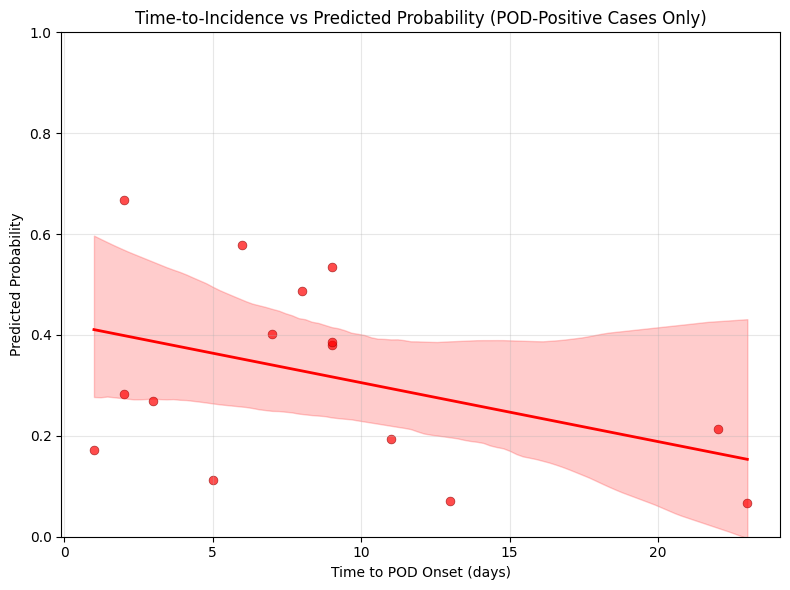


Analysis for POD-Positive Cases Only:
Number of patients: 15
Spearman correlation: -0.335 (p = 0.22163)
95% CI for correlation: [-0.831, 0.193]
Linear trendline slope: -0.0117
Linear trendline intercept: 0.4223
95% CI for slope (normal distribution): [-0.0273, 0.0042]


In [30]:
# Additional analysis: time-to-incidence vs predicted probability for positive cases only
positive_cases_mask = filtered_y_test == 1
if np.sum(positive_cases_mask) > 1:
    x_pos = np.asarray(filtered_interval[positive_cases_mask], dtype=np.float64).ravel()
    y_pos = np.asarray(filtered_y_test_proba[positive_cases_mask], dtype=np.float64).ravel()
    
    # Keep only finite values
    mask_pos = np.isfinite(x_pos) & np.isfinite(y_pos)
    x_pos_clean = x_pos[mask_pos]
    y_pos_clean = y_pos[mask_pos]
    
    if len(x_pos_clean) > 2:
        # Calculate Spearman correlation
        from scipy.stats import spearmanr
        spearman_corr_pos, spearman_p_pos = spearmanr(x_pos_clean, y_pos_clean)
        
        # Fit a linear trendline for visualization
        z_pos = np.polyfit(x_pos_clean, y_pos_clean, 1)
        p_pos = np.poly1d(z_pos)
        
        # Generate bootstrap confidence intervals for the regression line
        n_bootstrap = 500
        correlations = []
        slopes = []
        intercepts = []
        
        for _ in range(n_bootstrap):
            indices = np.random.choice(len(x_pos_clean), size=len(x_pos_clean), replace=True)
            x_boot = x_pos_clean[indices]
            y_boot = y_pos_clean[indices]
            
            # Calculate correlation
            corr_boot, _ = spearmanr(x_boot, y_boot)
            correlations.append(corr_boot)
            
            # Calculate regression coefficients
            z_boot = np.polyfit(x_boot, y_boot, 1)
            slopes.append(z_boot[0])
            intercepts.append(z_boot[1])
        
        correlations = np.array(correlations)
        slopes = np.array(slopes)
        intercepts = np.array(intercepts)
        
        # Calculate confidence intervals for correlation
        ci_lower = np.percentile(correlations, 2.5)
        ci_upper = np.percentile(correlations, 97.5)
        
        # Calculate confidence intervals for slope using normal distribution
        slope_mean = np.mean(slopes)
        slope_std = np.std(slopes, ddof=1)
        from scipy.stats import norm
        slope_ci_lower = norm.ppf(0.025, loc=slope_mean, scale=slope_std)
        slope_ci_upper = norm.ppf(0.975, loc=slope_mean, scale=slope_std)
        
        # Create plot
        plt.figure(figsize=(8, 6))
        plt.scatter(x_pos_clean, y_pos_clean, alpha=0.7, s=40, color='red', edgecolors='darkred', linewidth=0.5)
        
        # Plot trendline in red
        x_trend = np.linspace(x_pos_clean.min(), x_pos_clean.max(), 100)
        y_trend = p_pos(x_trend)
        plt.plot(x_trend, y_trend, 'red', linewidth=2)
        
        # Calculate error envelope using bootstrap regression coefficients
        y_bootstrap_lines = []
        for slope, intercept in zip(slopes, intercepts):
            y_boot_line = slope * x_trend + intercept
            y_bootstrap_lines.append(y_boot_line)
        
        y_bootstrap_lines = np.array(y_bootstrap_lines)
        y_lower_envelope = np.percentile(y_bootstrap_lines, 2.5, axis=0)
        y_upper_envelope = np.percentile(y_bootstrap_lines, 97.5, axis=0)
        
        plt.fill_between(x_trend, y_lower_envelope, y_upper_envelope, alpha=0.2, color='red')
        
        plt.xlabel('Time to POD Onset (days)')
        plt.ylabel('Predicted Probability')
        plt.title('Time-to-Incidence vs Predicted Probability (POD-Positive Cases Only)')
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\nAnalysis for POD-Positive Cases Only:")
        print(f"Number of patients: {len(x_pos_clean)}")
        print(f"Spearman correlation: {spearman_corr_pos:.3f} (p = {spearman_p_pos:.5g})")
        print(f"95% CI for correlation: [{ci_lower:.3f}, {ci_upper:.3f}]")
        print(f"Linear trendline slope: {z_pos[0]:.4f}")
        print(f"Linear trendline intercept: {z_pos[1]:.4f}")
        print(f"95% CI for slope (normal distribution): [{slope_ci_lower:.4f}, {slope_ci_upper:.4f}]")
    else:
        print(f"Insufficient data points for positive cases analysis: {len(x_pos_clean)} points")
else:
    print("No positive cases found for time-to-incidence analysis")

## Comparison with CAM-ICU

In [ ]:
x1= pd.read_csv('eeg_rid_supreme_labelled.csv')
x2= pd.read_csv('icu_cam.csv')

# Convert date columns to datetime with error handling
x1['dtend'] = pd.to_datetime(x1['dtend'], errors='coerce')
x2['기록작성일시'] = pd.to_datetime(x2['기록작성일시'], errors='coerce')

# Fill invalid dates with the last valid date in each series
x1['dtend'] = x1['dtend'].fillna(x1['dtend'].max())
x2['기록작성일시'] = x2['기록작성일시'].fillna(x2['기록작성일시'].max())

# Initialize label_cam column with NaN
x1['label_cam'] = np.nan

# Process each row in x1
for idx in tqdm(range(len(x1)), desc='Processing CAM labels'):
    hid = x1.loc[idx, 'hid']
    dtend = x1.loc[idx, 'dtend']
    
    # Find matching rows in x2
    matching_rows = x2[x2['연구별 환자 ID'] == hid]
    
    if len(matching_rows) > 0:
        # Filter rows where dtend < 기록작성일시
        filtered_rows = matching_rows[(dtend < matching_rows['기록작성일시'])] 
        
        if len(filtered_rows) > 0:
            # Check if any VALUE is '양성'
            if (filtered_rows['VALUE'] == '양성').any():
                x1.loc[idx, 'label_cam'] = 1
            else:
                x1.loc[idx, 'label_cam'] = 0
        else:
            x1.loc[idx, 'label_cam'] = 0
    # If no matching rows, label_cam remains NaN

In [ ]:
# Print evaluation metrics comparing x1['label'] and x1['label_cam']
print("\nEvaluation metrics for label alignment:")
print("="*50)

# Filter out rows where either label is NaN
valid_mask = ~(x1['label'].isna() | x1['label_cam'].isna())
valid_data = x1[valid_mask]

if len(valid_data) > 0:
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    y_true = valid_data['label_cam'].astype(int)
    y_pred = valid_data['label'].astype(int)
    
    print(f"Total samples with both labels: {len(valid_data)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.3f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Create a more detailed confusion matrix visualization
    plt.figure(figsize=(8, 6))
    
    # Define class labels
    class_labels = ['Non-Delirium (0)', 'Delirium (1)']
    
    # Create heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix: EEG Label vs CAM Label Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted (EEG Label)', fontsize=12)
    plt.ylabel('True (CAM Label)', fontsize=12)
    
    # Add text annotations with percentages
    total = cm.sum()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed confusion matrix breakdown
    print("\nDetailed Confusion Matrix Breakdown:")
    print(f"True Negatives (CAM=0, EEG=0): {cm[0,0]} ({cm[0,0]/total*100:.1f}%)")
    print(f"False Positives (CAM=0, EEG=1): {cm[0,1]} ({cm[0,1]/total*100:.1f}%)")
    print(f"False Negatives (CAM=1, EEG=0): {cm[1,0]} ({cm[1,0]/total*100:.1f}%)")
    print(f"True Positives (CAM=1, EEG=1): {cm[1,1]} ({cm[1,1]/total*100:.1f}%)")
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))
    
    # Show agreement percentage
    agreement = (y_true == y_pred).mean()
    print(f"\nLabel Agreement: {agreement:.3f} ({agreement*100:.1f}%)")
    
else:
    print("No valid samples found with both labels available for comparison")

print(f"\nLabel distribution:")
print(f"x1['label'] - {x1['label'].value_counts()}")
print(f"x1['label_cam'] - {x1['label_cam'].value_counts()}")

In [ ]:
F_f = np.load('F_f.npy', allow_pickle=True)

# Create Y_normalized_f_cam by matching F_f elements with x1['filename'] and extracting corresponding 'label_cam'
Y_normalized_f_cam = []

for filename in tqdm(F_f, desc="Processing filenames"):
    # Find matching rows in x1 where filename matches
    matching_rows = x1[x1['filename'] == filename]
    
    if not matching_rows.empty:
        # Get the label_cam value from the first matching row
        label_cam = matching_rows['label_cam'].iloc[0]
        Y_normalized_f_cam.append(label_cam)
    else:
        # If no match found, append NaN
        print(f"No match found for filename: {filename}")
        Y_normalized_f_cam.append(np.nan)

# Convert to numpy array
Y_normalized_f_cam = np.array(Y_normalized_f_cam)

# Save the array
np.save('Y_normalized_f_cam.npy', Y_normalized_f_cam)


=== Subgroup: CAM_ICU_exists ===
Subgroup test set - Label 0: 62009, Label 1: 422


[Test][CAM_ICU_exists]:   0%|          | 0/3902 [00:00<?, ?it/s]

AUROC 0.870 (95% CI: 0.811-0.936)
AUPRC 0.038 (95% CI: 0.020-0.095)
F1 Score 0.026 (95% CI: 0.014-0.041)
Precision 0.013 (95% CI: 0.007-0.021)
Recall 0.933 (95% CI: 0.774-1.000)
Test Accuracy 0.547 (95% CI: 0.528-0.567)
Brier Score 0.031 (95% CI: 0.028-0.034)
ICI 0.107 (95% CI: 0.101-0.114)


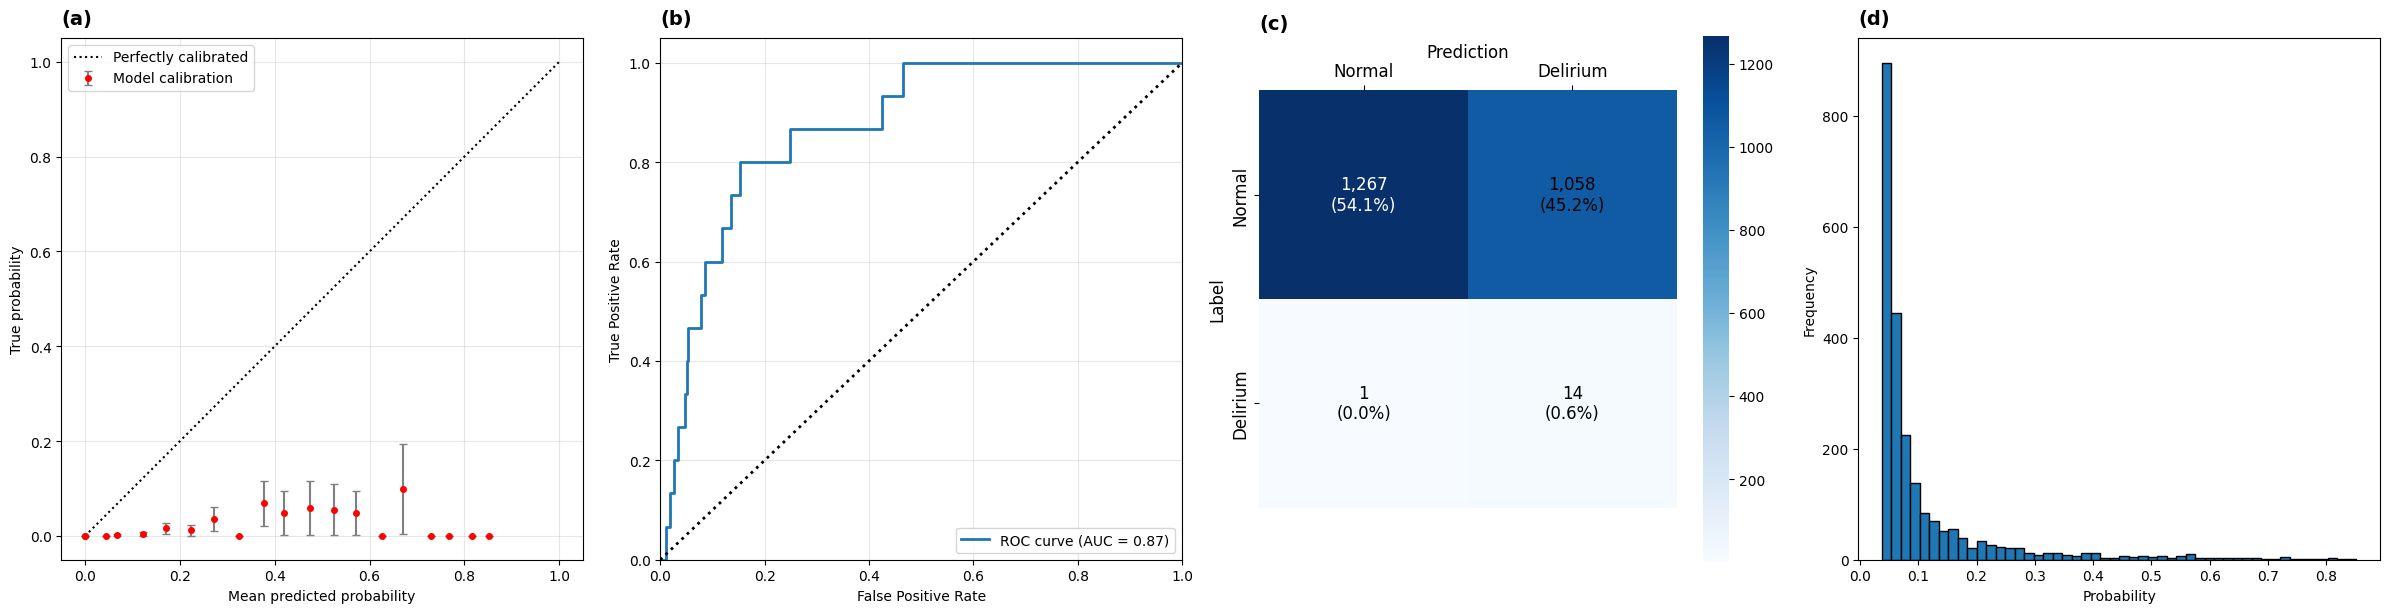

AUROC 0.839 (95% CI: 0.798-0.878)
AUPRC 0.123 (95% CI: 0.078-0.226)
F1 Score 0.085 (95% CI: 0.067-0.109)
Precision 0.045 (95% CI: 0.035-0.058)
Recall 0.923 (95% CI: 0.840-0.992)
Test Accuracy 0.561 (95% CI: 0.545-0.576)
Brier Score 0.037 (95% CI: 0.032-0.041)
ICI 0.091 (95% CI: 0.086-0.097)


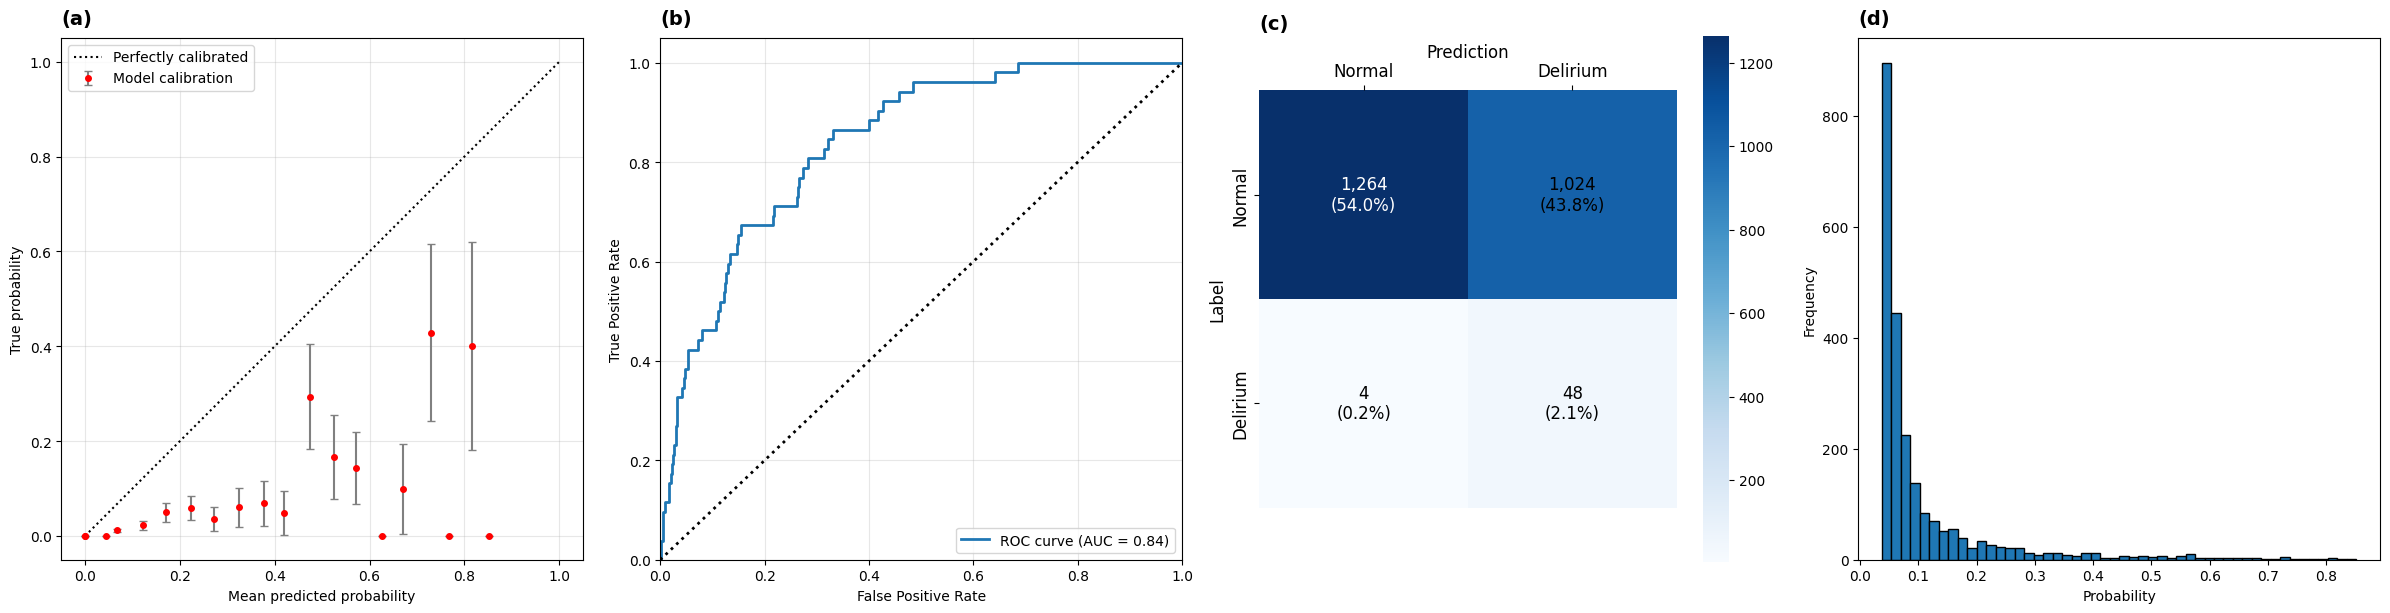


AUROC Comparison for CAM_ICU_exists:
EEG labels AUROC: 0.8702
CAM labels AUROC: 0.8385
Difference (EEG - CAM): 0.0317

AUROC Comparison for CAM_ICU_exists:
EEG labels AUROC: 0.8702
CAM labels AUROC: 0.8385
Difference (EEG - CAM): 0.0317

AUPRC Comparison for CAM_ICU_exists:
EEG labels AUPRC: 0.0377
CAM labels AUPRC: 0.1231
Difference (EEG - CAM): -0.0854
AUROC Permutation test p-value: 0.3707
AUPRC Permutation test p-value: 0.0066
95% CI for AUROC difference: [-0.0468, 0.1016]
95% CI for AUPRC difference: [-0.1766, -0.0241]


0

In [3]:
# Subgroup Analysis
def safe_auc(y_true, y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    # Need both classes present
    u = np.unique(y_true[~np.isnan(y_true)])
    if u.size < 2:
        return np.nan
    return roc_auc_score(y_true, y_score)

def safe_auprc(y_true, y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    # Need both classes present
    u = np.unique(y_true[~np.isnan(y_true)])
    if u.size < 2:
        return np.nan
    return average_precision_score(y_true, y_score)

def paired_bootstrap_auc_diff(y1, y2, p, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(p)
    diffs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        a1 = safe_auc(y1[idx], p[idx])
        a2 = safe_auc(y2[idx], p[idx])
        if np.isfinite(a1) and np.isfinite(a2):
            diffs.append(a1 - a2)
    diffs = np.array(diffs)
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    return (ci_low, ci_high), diffs

def paired_bootstrap_auprc_diff(y1, y2, p, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(p)
    diffs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        a1 = safe_auprc(y1[idx], p[idx])
        a2 = safe_auprc(y2[idx], p[idx])
        if np.isfinite(a1) and np.isfinite(a2):
            diffs.append(a1 - a2)
    diffs = np.array(diffs)
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    return (ci_low, ci_high), diffs

def paired_permutation_pvalue(y1, y2, p, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(p)
    obs = safe_auc(y1, p) - safe_auc(y2, p)
    null = []
    for _ in range(n_perm):
        swap = rng.random(n) < 0.5
        y1p = y1.copy()
        y2p = y2.copy()
        tmp = y1p[swap].copy()
        y1p[swap] = y2p[swap]
        y2p[swap] = tmp
        a1 = safe_auc(y1p, p)
        a2 = safe_auc(y2p, p)
        if np.isfinite(a1) and np.isfinite(a2):
            null.append(a1 - a2)
    null = np.asarray(null)
    p_val = (np.sum(np.abs(null) >= np.abs(obs)) + 1) / (len(null) + 1)
    return obs, p_val, null

def paired_permutation_pvalue_auprc(y1, y2, p, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(p)
    obs = safe_auprc(y1, p) - safe_auprc(y2, p)
    null = []
    for _ in range(n_perm):
        swap = rng.random(n) < 0.5
        y1p = y1.copy()
        y2p = y2.copy()
        tmp = y1p[swap].copy()
        y1p[swap] = y2p[swap]
        y2p[swap] = tmp
        a1 = safe_auprc(y1p, p)
        a2 = safe_auprc(y2p, p)
        if np.isfinite(a1) and np.isfinite(a2):
            null.append(a1 - a2)
    null = np.asarray(null)
    p_val = (np.sum(np.abs(null) >= np.abs(obs)) + 1) / (len(null) + 1)
    return obs, p_val, null

# Load only what we need initially
test_ids = np.load('test_ids.npy', allow_pickle=True)
ID = np.load('C_f.npy', mmap_mode='r')
GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')

# Create combined mask first
general_mask = (GENERAL == 1)
test_mask = np.isin(ID[general_mask], test_ids)

# Load data with masks applied immediately
X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')[general_mask][test_mask]
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')[general_mask][test_mask]
A = np.load('A_f.npy', mmap_mode='r')[general_mask][test_mask]
S = np.load('S_f.npy', mmap_mode='r')[general_mask][test_mask]
P = np.load('P_f.npy', mmap_mode='r')[general_mask][test_mask].copy()
FILE = np.load('F_f.npy', mmap_mode='r')[general_mask][test_mask]
Y_cam = np.load('Y_normalized_f_cam.npy', mmap_mode='r')[general_mask][test_mask]

Y_cam = np.where(np.isnan(Y_cam), 0, np.where((Y_cam == 1) | (Y_normalized == 1), 1, 0))
#Y_cam = np.where(np.isnan(Y_cam), np.nan, np.where((Y_cam == 1) | (Y_normalized == 1), 1, 0))

# Clean up masks
del general_mask, test_mask, ID, GENERAL

# Load model components
with open('calibration.pkl', 'rb') as f:
    calib = pickle.load(f)
Youden = np.load('youden.npy').item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(f'final_model_full_training.pth', map_location=device)
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
del checkpoint

# Define subgroups
subgroups = [
    ("CAM_ICU_exists", lambda: ~np.isnan(Y_cam)),
]

for subgroup_name, subgroup_mask_fn in subgroups:
    print(f"\n=== Subgroup: {subgroup_name} ===")
    mask = subgroup_mask_fn()
    if np.sum(mask) == 0:
        print(f"No samples in subgroup {subgroup_name}. Skipping.")
        continue

    # Apply subgroup mask
    X_sub = X_normalized[mask]
    y_sub = Y_normalized[mask]
    y_cam_sub = Y_cam[mask]
    a_sub = A[mask]
    s_sub = S[mask]
    p_sub = P[mask].copy()
    file_sub = FILE[mask]

    test_label_0 = np.sum(y_sub == 0)
    test_label_1 = np.sum(y_sub == 1)
    print(f"Subgroup test set - Label 0: {test_label_0}, Label 1: {test_label_1}")

    # Process in smaller batches to save memory
    test_dataset = ChunkedDataset(X_sub, a_sub, s_sub, y_sub)
    test_loader = DataLoader(test_dataset, batch_size=min(BATCH, 32))  # Smaller batch size
    
    test_preds_list = []
    test_targets_list = []

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'[Test][{subgroup_name}]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            
            model.eval()
            outputs = model(inputs, age, sex, adj)
            
            # Move to CPU immediately and convert to list to save GPU memory
            test_preds_list.extend(outputs.detach().cpu().numpy().ravel().tolist())
            test_targets_list.extend(targets.detach().cpu().numpy().tolist())
            
            # Clear GPU cache periodically
            if len(test_preds_list) % (BATCH * 10) == 0:
                torch.cuda.empty_cache()

    # Convert to numpy arrays
    test_preds = np.array(test_preds_list)
    test_targets = np.array(test_targets_list)
    
    # Clear lists to free memory
    del test_preds_list, test_targets_list, test_dataset, test_loader

    # Calibrate predictions
    test_preds = calib.calibrate(test_preds)
    
    # Average predictions by file ID
    unique_test_ids = np.unique(file_sub)
    n_unique = len(unique_test_ids)
    
    # Pre-allocate arrays for efficiency
    averaged_test_preds = np.zeros(n_unique)
    averaged_test_targets = np.zeros(n_unique)
    averaged_p_test = np.zeros(n_unique)
    averaged_y_cam_test = np.zeros(n_unique)

    for i, test_id in enumerate(unique_test_ids):
        id_indices = file_sub == test_id
        if np.any(id_indices):
            averaged_test_preds[i] = np.mean(test_preds[id_indices])
            averaged_p_test[i] = np.nanmean(p_sub[id_indices])
            averaged_y_cam_test[i] = np.nanmean(y_cam_sub[id_indices])
            averaged_test_targets[i] = test_targets[id_indices][0]

    # Filter out NaN values
    valid_indices = ~np.isnan(averaged_p_test)
    filtered_y_test_proba = averaged_test_preds[valid_indices]
    filtered_y_test = averaged_test_targets[valid_indices]
    filtered_y_cam_test = averaged_y_cam_test[valid_indices]
    filtered_y_pred_test = (filtered_y_test_proba > Youden).astype(int)
    
    # Check for NaN values before evaluation
    if np.any(np.isnan(filtered_y_cam_test)):
        print(f"Warning: NaN values found in CAM labels for {subgroup_name}")
        # Remove NaN values from CAM evaluation
        cam_valid = ~np.isnan(filtered_y_cam_test)
        if np.any(cam_valid):
            draw_model_evaluation_plots(filtered_y_test[cam_valid], filtered_y_test_proba[cam_valid], 
                                      filtered_y_pred_test[cam_valid], n_bins=20, n_bootstraps=100)
            draw_model_evaluation_plots(filtered_y_cam_test[cam_valid], filtered_y_test_proba[cam_valid], 
                                      filtered_y_pred_test[cam_valid], n_bins=20, n_bootstraps=100)
    else:
        draw_model_evaluation_plots(filtered_y_test, filtered_y_test_proba, filtered_y_pred_test, n_bins=20, n_bootstraps=100)
        draw_model_evaluation_plots(filtered_y_cam_test, filtered_y_test_proba, filtered_y_pred_test, n_bins=20, n_bootstraps=100)
    
    # Compare AUROC between EEG and CAM labels with bootstrap t-test
    cam_valid = ~np.isnan(filtered_y_cam_test)
    if np.any(cam_valid):
        from sklearn.metrics import roc_auc_score, average_precision_score
        from scipy import stats
        
        # Calculate AUROC for both label types
        auroc_eeg = roc_auc_score(filtered_y_test[cam_valid], filtered_y_test_proba[cam_valid])
        auroc_cam = roc_auc_score(filtered_y_cam_test[cam_valid], filtered_y_test_proba[cam_valid])
        
        print(f"\nAUROC Comparison for {subgroup_name}:")
        print(f"EEG labels AUROC: {auroc_eeg:.4f}")
        print(f"CAM labels AUROC: {auroc_cam:.4f}")
        print(f"Difference (EEG - CAM): {auroc_eeg - auroc_cam:.4f}")
        
        # Bootstrap t-test for AUROC comparison
        n_bootstrap = 100
        auroc_diff_bootstrap = []
        
        # Get valid data for bootstrap
        y_eeg_valid = filtered_y_test[cam_valid]
        y_cam_valid = filtered_y_cam_test[cam_valid]
        y_proba_valid = filtered_y_test_proba[cam_valid]
        n_samples = len(y_eeg_valid)

        # After computing y_eeg_valid, y_cam_valid, y_proba_valid
        auroc_eeg = safe_auc(y_eeg_valid, y_proba_valid)
        auroc_cam = safe_auc(y_cam_valid, y_proba_valid)
        auprc_eeg = safe_auprc(y_eeg_valid, y_proba_valid)
        auprc_cam = safe_auprc(y_cam_valid, y_proba_valid)
        
        print(f"\nAUROC Comparison for {subgroup_name}:")
        print(f"EEG labels AUROC: {auroc_eeg:.4f}")
        print(f"CAM labels AUROC: {auroc_cam:.4f}")
        print(f"Difference (EEG - CAM): {auroc_eeg - auroc_cam:.4f}")

        print(f"\nAUPRC Comparison for {subgroup_name}:")
        print(f"EEG labels AUPRC: {auprc_eeg:.4f}")
        print(f"CAM labels AUPRC: {auprc_cam:.4f}")
        print(f"Difference (EEG - CAM): {auprc_eeg - auprc_cam:.4f}")

        # Paired permutation p-value for AUROC
        diff_obs, p_value, null_dist = paired_permutation_pvalue(y_eeg_valid, y_cam_valid, y_proba_valid, n_perm=5000, seed=42)
        print(f"AUROC Permutation test p-value: {p_value:.4f}")

        # Paired permutation p-value for AUPRC
        diff_obs_auprc, p_value_auprc, null_dist_auprc = paired_permutation_pvalue_auprc(y_eeg_valid, y_cam_valid, y_proba_valid, n_perm=5000, seed=42)
        print(f"AUPRC Permutation test p-value: {p_value_auprc:.4f}")

        # Paired bootstrap CI for AUROC
        (ci_low, ci_high), diffs = paired_bootstrap_auc_diff(y_eeg_valid, y_cam_valid, y_proba_valid, n_boot=2000, seed=42)
        print(f"95% CI for AUROC difference: [{ci_low:.4f}, {ci_high:.4f}]")

        # Paired bootstrap CI for AUPRC
        (ci_low_auprc, ci_high_auprc), diffs_auprc = paired_bootstrap_auprc_diff(y_eeg_valid, y_cam_valid, y_proba_valid, n_boot=2000, seed=42)
        print(f"95% CI for AUPRC difference: [{ci_low_auprc:.4f}, {ci_high_auprc:.4f}]")
    
    # Clean up memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # Delete subgroup-specific variables
    del X_sub, y_sub, y_cam_sub, a_sub, s_sub, p_sub, file_sub
    del test_preds, test_targets, averaged_test_preds, averaged_test_targets
    del averaged_p_test, averaged_y_cam_test, filtered_y_test_proba
    del filtered_y_test, filtered_y_cam_test, filtered_y_pred_test

# Final cleanup
del model, X_normalized, Y_normalized, A, S, P, FILE, Y_cam
torch.cuda.empty_cache()
gc.collect()

## Sample Size calculation

In [ ]:
from pmvalsampsize.pmvalsampsize import pmvalsampsize, summary

# Main scenario: overall study prevalence (444 / 35,115 ≈ 0.01264)
samplesize = pmvalsampsize(
	type="b",
	prevalence=444 / 35115,     # ≈ 0.01264
	cstatistic=0.80,         # AUROC from original-ratio test set
	cstatciwidth=0.10,        # target CI width for AUROC (tune as needed)
	cslope=1.0,               # assume well-calibrated model
	csciwidth=0.20,           # target CI width for calibration slope
	oe=1.0,                   # assume O/E near 1
	oeciwidth=0.20,           # target CI width for O/E
	lpcstat=0.0,              # simulate LP via normal assumptions using AUROC + prevalence
	graph=False,
	noprint=False,
	verbose=True              # Add missing verbose parameter
)
summary(samplesize)

## Weighted loss

In [ ]:
# Training
set_seeds()

train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r').astype(np.float32)
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')
GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')

general_mask = (GENERAL == 1)
X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]

train_mask = np.isin(ID, train_ids)
X_train_full = X_normalized[train_mask]
y_train_full = Y_normalized[train_mask]    
a_train_full = A[train_mask]
s_train_full = S[train_mask]
ID_train_full = ID[train_mask]
FILE_train_full = FILE[train_mask]

del X_normalized
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Calculate class weights for weighted loss
unique_labels, label_counts = np.unique(y_train_full, return_counts=True)
total_samples = len(y_train_full)
class_weights = total_samples / (len(unique_labels) * label_counts)
print(f"Class distribution: {dict(zip(unique_labels, label_counts))}")
print(f"Class weights: {dict(zip(unique_labels, class_weights))}")

# Convert to tensor for use in loss function
class_weights_tensor = torch.FloatTensor(class_weights)

unique_ids = np.unique(ID_train_full)
print(f"Total unique IDs: {len(unique_ids)}")
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
fold_step_sizes = []

fold_num = 1
for train_idx, val_idx in kf.split(unique_ids):
    print(f"\n{'='*20} Fold {fold_num} {'='*20}")
    
    fold_train_ids = unique_ids[train_idx]
    fold_val_ids = unique_ids[val_idx]
    
    fold_train_mask = np.isin(ID_train_full, fold_train_ids)
    fold_val_mask = np.isin(ID_train_full, fold_val_ids)
    
    X_fold_train = X_train_full[fold_train_mask]
    y_fold_train = y_train_full[fold_train_mask]
    a_fold_train = a_train_full[fold_train_mask]
    s_fold_train = s_train_full[fold_train_mask]
    
    X_fold_val = X_train_full[fold_val_mask]
    y_fold_val = y_train_full[fold_val_mask]
    a_fold_val = a_train_full[fold_val_mask]
    s_fold_val = s_train_full[fold_val_mask]
    
    step_size = train_fold(
        X_fold_train, y_fold_train, a_fold_train, s_fold_train,
        X_fold_val, y_fold_val, a_fold_val, s_fold_val,
        fold_num
    )
    fold_step_sizes.append(step_size)
    fold_num += 1


mean_step_size = int(np.mean(fold_step_sizes))
print(f"\nStep sizes for each fold: {fold_step_sizes}")
print(f"Mean step size: {mean_step_size}")
print(f"\n{'='*20} Training on Full Dataset {'='*20}")

full_train_dataset = ChunkedDataset(X_train_full, a_train_full, s_train_full, y_train_full)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH, shuffle=True)
full_train_label_0 = np.sum(y_train_full[:, None] == 0)
full_train_label_1 = np.sum(y_train_full[:, None] == 1)
print(f"Full training set - Label 0: {full_train_label_0}, Label 1: {full_train_label_1}")
steps_per_epoch = len(full_train_loader)
epochs_to_train = max(1, mean_step_size // steps_per_epoch)
remaining_steps = mean_step_size % steps_per_epoch

print(f"Training for {epochs_to_train} epochs and {remaining_steps} additional steps")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = CombinedGCNCNN(adj=adj).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=LR, weight_decay=1e-5)

# Use weighted BCE loss to handle class imbalance
pos_weight = torch.tensor([class_weights[1] / class_weights[0]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

final_model.train()
step_counter = 0
early_stop = False

for epoch in range(epochs_to_train + 1):
    if early_stop:
        break
    train_pbar = tqdm(full_train_loader, desc=f'Full Training - Epoch {epoch+1}/{epochs_to_train+1}')
    running_loss = 0.0
    
    for batch_idx, (inputs, age, sex, targets) in enumerate(train_pbar):
        if step_counter >= mean_step_size:
            early_stop = True
            break
            
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Get logits instead of probabilities for BCEWithLogitsLoss
        logits = final_model(inputs, age, sex, adj)
        
        # Use weighted BCE loss
        bce_loss = criterion(logits, targets)
        l2_reg = 0.0
        for param in final_model.parameters():
            l2_reg += torch.norm(param, 2)
        
        reg_coef = 0.001
        loss = bce_loss + reg_coef * l2_reg
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step_counter += 1
        if epoch == epochs_to_train and batch_idx >= remaining_steps - 1:
            early_stop = True
            break
        train_pbar.set_postfix({'Weighted BCE': f'{running_loss/(batch_idx+1):.4f}', 'Step': f'{step_counter}/{mean_step_size}'})

#Step sizes for each fold: [2526, 6245, 8757, 5048, 2504]
#Mean step size: 5016
torch.save({
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'steps_trained': step_counter,
    'mean_step_size': mean_step_size,
    'class_weights': class_weights,
    'pos_weight': pos_weight.cpu().numpy()
}, 'final_model_full_training_weighted.pth')


In [ ]:
#Inference
train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')
general_mask = (GENERAL == 1)

X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]

train_mask = np.isin(ID, train_ids)
X_train = X_normalized[train_mask]
y_train = Y_normalized[train_mask]

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
a_train = A[train_mask]
s_train = S[train_mask]
p_train = P[train_mask].copy()
ID_train = ID[train_mask]
valid_indices = ~np.isnan(p_train)
filtered_y_train = y_train[valid_indices]
filtered_p_train = p_train[valid_indices]
Youden_p = youden(filtered_y_train, filtered_p_train)
orig_train_dataset = ChunkedDataset(X_train, a_train, s_train, y_train)
orig_train_loader = DataLoader(orig_train_dataset, batch_size=BATCH)
train_label_0 = np.sum(y_train[:, None] == 0)
train_label_1 = np.sum(y_train[:, None] == 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedGCNCNN(adj=adj).to(device)
models = []
calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500, logodds_scale=False)
checkpoint = torch.load(f'final_model_full_training_weighted.pth')
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
models.append(model)

train_preds_all_models = []
train_targets = []

with torch.no_grad():
    train_pbar = tqdm(orig_train_loader, desc=f'[Train]')
    for inputs, age, sex, targets in train_pbar:
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        batch_preds = []
        for model in models:
            model.eval()
            outputs = model(inputs, age, sex, adj)
            batch_preds.append(outputs.detach().cpu().numpy())
        train_preds_all_models.extend(batch_preds[0].ravel())
        train_targets.extend(targets.detach().cpu().numpy())
train_preds = np.array(train_preds_all_models).ravel()
train_targets = np.array(train_targets).ravel()
Youden = youden(train_targets, train_preds)
calib.fit(train_preds, train_targets)

with open('calibration_weighted.pkl', 'wb') as f:
    pickle.dump(calib, f)
np.save('youden_weighted.npy', Youden)

print(f'Youden Index : {Youden:.3f}')
del orig_train_loader
for test_ids_file in ['test_ids.npy','test_ids_1.npy', 'test_ids_2.npy']:
    test_ids = np.load(test_ids_file, allow_pickle=True)
    test_mask = np.isin(ID, test_ids)
    X_test = X_normalized[test_mask] 
    y_test = Y_normalized[test_mask]
    a_test = A[test_mask]
    s_test = S[test_mask]
    p_test = P[test_mask].copy()
    
    test_dataset = ChunkedDataset(X_test, a_test, s_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH)
    del test_dataset
    
    test_label_0 = np.sum(y_test[:, None] == 0)
    test_label_1 = np.sum(y_test[:, None] == 1)
    print(f"Test set - Label 0: {test_label_0}, Label 1: {test_label_1}")
    
    test_preds_all_models = []
    test_targets = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'[Test]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            batch_preds = []
            for model in models:
                model.eval()
                outputs = model(inputs, age, sex, adj)
                batch_preds.append(outputs.detach().cpu().numpy())
            test_preds_all_models.extend(batch_preds[0].ravel())
            test_targets.extend(targets.detach().cpu().numpy())
    test_preds = np.array(test_preds_all_models)
    test_targets = np.array(test_targets)

    valid_indices = ~np.isnan(p_test)
    filtered_test_preds = test_preds[valid_indices]
    filtered_p_test = p_test[valid_indices]
    test_ids_expanded = FILE[test_mask]
    test_preds = calib.calibrate(test_preds)
    unique_test_ids = np.unique(test_ids_expanded)
    averaged_test_preds = []
    averaged_test_targets = []
    averaged_p_test = []

    for test_id in unique_test_ids:
        id_indices = np.where(test_ids_expanded == test_id)[0]
        if len(id_indices) > 0:
            id_preds = test_preds[id_indices]
            id_p_test = p_test[id_indices]
            averaged_test_preds.append(np.mean(id_preds))
            averaged_p_test.append(np.nanmean(id_p_test))
            averaged_test_targets.append(test_targets[id_indices[0]])

    y_test = np.array(averaged_test_targets).ravel()
    y_test_proba = np.array(averaged_test_preds)
    p_test_mean = np.array(averaged_p_test)
    valid_indices = ~np.isnan(p_test_mean)
    filtered_y_test_proba = y_test_proba[valid_indices]
    filtered_y_test = y_test[valid_indices]
    filtered_y_pred_test = (filtered_y_test_proba > Youden).astype(int)
    np.save(f'y_test_proba_weighted_{test_ids_file}', filtered_y_test_proba)
    if test_ids_file == 'test_ids.npy':
        np.save('y_test.npy',filtered_y_test)
    try:
        draw_model_evaluation_plots(filtered_y_test, filtered_y_test_proba, filtered_y_pred_test, n_bins=20)
    except:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    del test_loader

In [7]:
y_test = np.load('y_test.npy')
y_test_proba_1 = np.load('y_test_proba_weighted_test_ids.npy')
y_test_proba_2 = np.load('y_test_proba_test_ids.npy')

print(f"Delong's test P = {delong_roc_test(y_test, y_test_proba_1,y_test_proba_2)[0][0]:.3f}")

Delong's test P = 0.166


## Spatial and Temporal Correlation Analyses

In [9]:
X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

GENERAL = np.load('GENERAL_f.npy', mmap_mode='r')
general_mask = (GENERAL == 1)

X_normalized = X_normalized[general_mask]
Y_normalized = Y_normalized[general_mask]
ID = ID[general_mask]
FILE = FILE[general_mask]
A = A[general_mask]
S = S[general_mask]
P = P[general_mask]

youden_threshold = np.load('youden.npy')
with open('calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

test_file = 'test_ids.npy'
test_ids = np.load(test_file, allow_pickle=True)
test_mask = np.isin(ID, test_ids)
X_test = X_normalized[test_mask] 
y_test = Y_normalized[test_mask]
a_test = A[test_mask]
s_test = S[test_mask]
p_test = P[test_mask].copy()
file_ids_test = FILE[test_mask]
del X_normalized, ID, A, S, Y_normalized, test_ids, test_mask
clear_memory()
test_dataset = ChunkedDataset(X_test, a_test, s_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH)
checkpoint = torch.load('final_model_full_training.pth', map_location=device)
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

# Utilities to collect calibrated predictions (probabilities) and labels
def collect_predictions(model, dataset, batch_size=BATCH, device=device):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for inputs, age, sex, targets in loader:
            inputs, age, sex = inputs.to(device), age.to(device), sex.to(device)
            outputs = model(inputs, age, sex, adj)  # sigmoid probabilities
            preds.extend(outputs.detach().cpu().numpy().ravel())
            labels.extend(targets.detach().cpu().numpy().ravel())
    return np.array(preds), np.array(labels)

# Ensure we have baseline calibrated predictions and baseline F1
test_dataset = ChunkedDataset(X_test, a_test, s_test, y_test)
baseline_probs, baseline_labels = collect_predictions(model, test_dataset)
baseline_probs = calib.calibrate(baseline_probs)
baseline_preds = (baseline_probs > youden_threshold).astype(int)
baseline_f1 = f1_score(baseline_labels, baseline_preds)
print(f"Baseline F1 (recomputed): {baseline_f1:.3f}")

Baseline F1 (recomputed): 0.030


Ablating channel L1


Processing L1:   0%|          | 0/63 [00:00<?, ?it/s]

Ablating channel L2


Processing L2:   0%|          | 0/63 [00:00<?, ?it/s]

Ablating channel R1


Processing R1:   0%|          | 0/63 [00:00<?, ?it/s]

Ablating channel R2


Processing R2:   0%|          | 0/63 [00:00<?, ?it/s]

Ablating channel L


Processing L:   0%|          | 0/63 [00:00<?, ?it/s]

Ablating channel R


Processing R:   0%|          | 0/63 [00:00<?, ?it/s]

,channel,delta_f1_pct,delta_prob_mean
1,L2,-33.171310,-0.054632
3,R2,-31.538490,-0.053161
5,R,-22.442353,-0.026827
4,L,-20.654132,-0.016078
0,L1,-18.990007,-0.010233
2,R1,-12.411765,0.000483


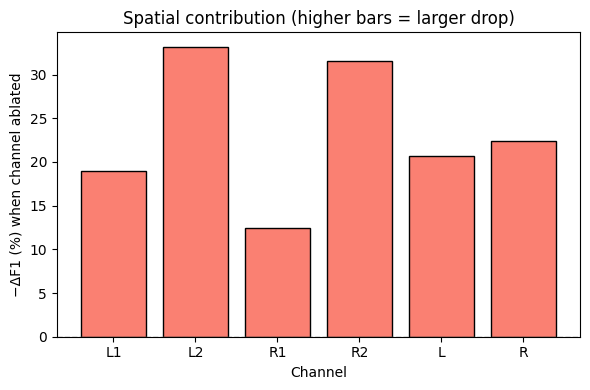

In [12]:
# 1) Spatial: per-channel ablation analysis (F1 change and probability drop)
channel_names = ["L1", "L2", "R1", "R2", "L", "R"]
channel_results = []

# Clear memory before starting
clear_memory()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Reduce batch size for memory efficiency
ABLATION_BATCH = 4

for ch in range(len(channel_names)):
    print(f"Ablating channel {channel_names[ch]}")
    
    # Process in smaller chunks to avoid memory issues
    chunk_size = 1000  # Process 1000 samples at a time
    n_samples = X_test.shape[0]
    
    f1_scores = []
    prob_diffs = []
    
    for start_idx in tqdm(range(0, n_samples, chunk_size), desc=f"Processing {channel_names[ch]}", leave=False):
        end_idx = min(start_idx + chunk_size, n_samples)
        
        # Create modified chunk
        X_chunk = X_test[start_idx:end_idx].copy()
        X_chunk[:, ch, :] = 0.0  # zero out the channel across time
        
        # Create dataset for this chunk
        chunk_dataset = ChunkedDataset(
            X_chunk, 
            a_test[start_idx:end_idx], 
            s_test[start_idx:end_idx], 
            y_test[start_idx:end_idx]
        )
        
        # Get predictions for this chunk
        chunk_probs, chunk_labels = collect_predictions(model, chunk_dataset, batch_size=ABLATION_BATCH)
        chunk_probs = calib.calibrate(chunk_probs)
        chunk_preds = (chunk_probs > youden_threshold).astype(int)
        
        # Calculate F1 for this chunk
        chunk_f1 = f1_score(chunk_labels, chunk_preds)
        f1_scores.append(chunk_f1)
        
        # Calculate probability difference for this chunk
        baseline_chunk = baseline_probs[start_idx:end_idx]
        prob_diff = (baseline_chunk - chunk_probs).mean()
        prob_diffs.append(prob_diff)
        
        # Clean up chunk data
        del X_chunk, chunk_dataset, chunk_probs, chunk_labels, chunk_preds
        clear_memory()
    
    # Aggregate results across chunks (weighted by chunk size)
    chunk_sizes = [min(chunk_size, n_samples - i) for i in range(0, n_samples, chunk_size)]
    total_samples = sum(chunk_sizes)
    
    f1_mod = sum(f1 * size for f1, size in zip(f1_scores, chunk_sizes)) / total_samples
    delta_prob = sum(diff * size for diff, size in zip(prob_diffs, chunk_sizes)) / total_samples
    
    delta_f1_pct = 100 * (f1_mod - baseline_f1) / (baseline_f1 + 1e-12)

    channel_results.append({
        'channel': channel_names[ch],
        'delta_f1_pct': delta_f1_pct,
        'delta_prob_mean': delta_prob
    })
    
    # Clear memory after each channel
    clear_memory()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Tabulate and visualize per-channel contributions
ch_df = pd.DataFrame(channel_results)
display(ch_df.sort_values('delta_f1_pct'))

plt.figure(figsize=(6, 4))
plt.bar(ch_df['channel'], -ch_df['delta_f1_pct'], color='salmon', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.ylabel('−ΔF1 (%) when channel ablated')
plt.xlabel('Channel')
plt.title('Spatial contribution (higher bars = larger drop)')
plt.tight_layout()
plt.show()

In [ ]:
# 2) Temporal and spatial gradients: saliency maps
# Produces channel-wise and time-wise importance via |∂prob/∂input|
def compute_saliency(model, dataset, max_batches=None, device=device):
    loader = DataLoader(dataset, batch_size=4, shuffle=False)  # Smaller batch size
    model.eval()
    n_time = X_test.shape[-1]
    sal_time_sum = np.zeros(n_time, dtype=np.float64)
    sal_ch_sum = np.zeros(len(channel_names), dtype=np.float64)
    n_seen = 0

    for b_idx, (inputs, age, sex, _) in enumerate(tqdm(loader, desc="Saliency")):
        if max_batches is not None and b_idx >= max_batches:
            break
        inputs = inputs.to(device)
        age, sex = age.to(device), sex.to(device)
        inputs.requires_grad_(True)

        outputs = model(inputs, age, sex, adj)  # shape (B, 1)
        # Use mean to accumulate gradients for the batch
        outputs.mean().backward()

        grads = inputs.grad.detach().abs().cpu().numpy()  # (B, C, L)
        sal_ch_sum += grads.mean(axis=(0, 2)) * grads.shape[0]
        sal_time_sum += grads.mean(axis=(0, 1)) * grads.shape[0]
        n_seen += grads.shape[0]

        # Clear gradients and variables
        model.zero_grad()
        inputs.requires_grad_(False)
        del inputs, age, sex, outputs, grads
        clear_memory()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    sal_ch = sal_ch_sum / max(n_seen, 1)
    sal_time = sal_time_sum / max(n_seen, 1)
    
    # Clean up arrays
    del sal_ch_sum, sal_time_sum
    clear_memory()
    
    return sal_ch, sal_time

sal_ch, sal_time = compute_saliency(model, test_dataset, max_batches=1000)  # Limit batches

# Normalize for visualization
sal_ch_norm = sal_ch / (sal_ch.max() + 1e-12)
sal_time_norm = sal_time / (sal_time.max() + 1e-12)
t_axis = np.arange(len(sal_time_norm)) / 80.0  # seconds

plt.figure(figsize=(6, 4))
plt.plot(t_axis, sal_time_norm, color='steelblue')
plt.xlabel('Time (s)')
plt.ylabel('Temporal saliency')
plt.title('Temporal importance (|∂prob/∂input|)')
plt.tight_layout()
plt.show()

# Clean up variables
del sal_ch, sal_time, sal_ch_norm, sal_time_norm, t_axis
clear_memory()
torch.cuda.empty_cache() if torch.cuda.is_available() else None